In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tarfile
import shutil
import pickle
from sklearn.model_selection import ParameterGrid, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, recall_score, accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

In [ ]:
%pip install lief==0.16.4
%pip install ember-mivia==0.0.6

In [ ]:
#PEFeatureExtractor è la classe di Ember che estrae caratteristiche dai file PE per machine learning.
from ember.features import PEFeatureExtractor
import pandas as pd

#Extract a feature vector from a binary file using the ember Feature Extractor
def get_ember_features(path, decompress = False):
    extractor = PEFeatureExtractor(print_feature_warning=False) #Crea un oggetto estrattore.
    if decompress:
      bytes = decompress_file(path)
    else:
      with open(path, 'rb') as f:
        bytes = f.read()

    features = [float(value) for value in extractor.feature_vector(bytes)] #Applica l’estrattore Ember al file binario e converte tutti i valori in float.
    return features


import zlib
def decompress_file(input_file_path):
    # read the file
    with open(input_file_path, 'rb') as f:
        compressed_data = f.read()

    # decompress the file with zlib
    decompressed_data = zlib.decompress(compressed_data)

    return decompressed_data

In [ ]:
def load_features_list(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
    if isinstance(data, dict) and "features" in data:
        return data["features"]
    return list(data)

In [ ]:

#Apre il file malware_features.pkl in modalità binaria ('rb')
#pickle.load(file) carica l’intero contenuto (cioè: una lista di feature vettoriali)

training_malware_features = load_features_list('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/malware_features.pkl')
training_benign_features = load_features_list('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/benign_features.pkl')


#codice carica vettori di feature (già estratti con ember + LIEF) da due file .pkl , salvati con pickle. Questi dati:
#non contengono i file binari .exe ma solo le feature (numeri) già estratte da essi→ quindi puoi usarli direttamente per classificazione, addestramento, ecc.

In [ ]:

#Apre il file malware_features.pkl in modalità binaria ('rb')
#pickle.load(file) carica l’intero contenuto (cioè: una lista di feature vettoriali)
validation_malware_features = load_features_list('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/validation/malware_features.pkl')
validation_benign_features = load_features_list('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/validation/benign_features.pkl')


#codice carica vettori di feature (già estratti con ember + LIEF) da due file .pkl , salvati con pickle. Questi dati:
#non contengono i file binari .exe ma solo le feature (numeri) già estratte da essi→ quindi puoi usarli direttamente per classificazione, addestramento, ecc.

In [ ]:

#Apre il file malware_features.pkl in modalità binaria ('rb')
#pickle.load(file) carica l’intero contenuto (cioè: una lista di feature vettoriali)

test_malware_features =load_features_list('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/test/malware_features.pkl')

test_benign_features = load_features_list('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/test/benign_features.pkl')




#codice carica vettori di feature (già estratti con ember + LIEF) da due file .pkl , salvati con pickle. Questi dati:
#non contengono i file binari .exe ma solo le feature (numeri) già estratte da essi→ quindi puoi usarli direttamente per classificazione, addestramento, ecc.

In [ ]:

#Apre il file malware_features.pkl in modalità binaria ('rb')
#pickle.load(file) carica l’intero contenuto (cioè: una lista di feature vettoriali)

dataset2_malware_features =load_features_list('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset2/general/malware_features.pkl')

dataset2_benign_features = load_features_list('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset2/general/benign_features.pkl')


#codice carica vettori di feature (già estratti con ember + LIEF) da due file .pkl , salvati con pickle. Questi dati:
#non contengono i file binari .exe ma solo le feature (numeri) già estratte da essi→ quindi puoi usarli direttamente per classificazione, addestramento, ecc.

In [ ]:
#training_malware_features = training_malware_features["features"]
#training_benign_features = training_benign_features["features"]

#Per ogni file malware, assegni etichetta 1.
#Per ogni file benigno, assegni 0.
training_malware_labels = list(np.ones(len(training_malware_features))) #Usa NumPy per creare un array di 1 (np.ones) o 0 (np.zeros)
training_benign_labels = list(np.zeros(len(training_benign_features))) #Poi converte in list() con list(...)

# Unione delle feature e delle etichette
x_train = np.array(training_malware_features + training_benign_features)
y_train = np.array(training_malware_labels + training_benign_labels)

# Replace NaN values with 0
x_train = np.nan_to_num(x_train, nan=0)

print("Size of Training Set:", len(x_train))
print("\tMalware count:", int(sum(y_train)))
print("\tBenign count:", int(len(x_train) - sum(y_train)))

Size of Training Set: 8967
	Malware count: 4591
	Benign count: 4376


In [ ]:
#Per ogni file malware, assegni etichetta 1.
#Per ogni file benigno, assegni 0.
validation_malware_labels = list(np.ones(len(validation_malware_features))) #Usa NumPy per creare un array di 1 (np.ones) o 0 (np.zeros)
validation_benign_labels = list(np.zeros(len(validation_benign_features))) #Poi converte in list() con list(...)

# Unione delle feature e delle etichette
x_validation = np.array(validation_malware_features + validation_benign_features)
y_validation = np.array(validation_malware_labels + validation_benign_labels)

# Replace NaN values with 0
x_validation = np.nan_to_num(x_validation, nan=0)

print("Size of validation Set:", len(x_validation))
print("\tMalware count:", int(sum(y_validation)))
print("\tBenign count:", int(len(x_validation) - sum(y_validation)))

Size of validation Set: 2550
	Malware count: 1310
	Benign count: 1240


In [ ]:
#Per ogni file malware, assegni etichetta 1.
#Per ogni file benigno, assegni 0.
test_malware_labels = list(np.ones(len(test_malware_features))) #Usa NumPy per creare un array di 1 (np.ones) o 0 (np.zeros)
test_benign_labels = list(np.zeros(len(test_benign_features))) #Poi converte in list() con list(...)

# Unione delle feature e delle etichette
x_test = np.array(test_malware_features + test_benign_features)
y_test = np.array(test_malware_labels + test_benign_labels)

# Replace NaN values with 0
x_test = np.nan_to_num(x_test, nan=0)

print("Size of test Set:", len(x_test))
print("\tMalware count:", int(sum(y_test)))
print("\tBenign count:", int(len(x_test) - sum(y_test)))

Size of test Set: 1271
	Malware count: 655
	Benign count: 616


In [ ]:
#Per ogni file malware, assegni etichetta 1.
#Per ogni file benigno, assegni 0.
dataset2_malware_labels = list(np.ones(len(dataset2_malware_features))) #Usa NumPy per creare un array di 1 (np.ones) o 0 (np.zeros)
dataset2_benign_labels = list(np.zeros(len(dataset2_benign_features))) #Poi converte in list() con list(...)

# Unione delle feature e delle etichette
x_dataset2 = np.array(dataset2_malware_features + dataset2_benign_features)
y_dataset2 = np.array(dataset2_malware_labels + dataset2_benign_labels)

# Replace NaN values with 0
x_dataset2 = np.nan_to_num(x_dataset2, nan=0)

print("Size of dataSet2:", len(x_dataset2))
print("\tMalware count:", int(sum(y_dataset2)))
print("\tBenign count:", int(len(x_dataset2) - sum(y_dataset2)))

Size of dataSet2: 1945
	Malware count: 990
	Benign count: 955


# Valutazione con accuracy


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score

# Definizione del classificatore base
rf_base = RandomForestClassifier(random_state=42)

# Griglia degli iperparametri
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 50],
    'min_samples_leaf': [10, 20, 30],
    'max_features': ['sqrt', 'log2']
}

# Crea la lista di tutte le combinazioni di parametri
param_list = list(ParameterGrid(param_grid))

# Variabili per tenere traccia del miglior modello
best_accuracy = 0
best_params = None
best_model = None

# Ciclo manuale su tutte le combinazioni
for params in param_list:

    model = RandomForestClassifier(random_state=42, **params)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_validation)
    accuracy = accuracy_score(y_validation, y_pred)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = model

# ✅ Risultati
print("Migliori parametri trovati massimizzando: Accuracy")
print(best_params)
print(f"📏 Accuracy: {best_accuracy:.3f}")

✅ Migliori parametri trovati massimizzando: Accuracy
{'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 50}
📏 Accuracy: 1.000


# Valutazione con F1 score

In [ ]:
# Definizione del classificatore base
rf_base = RandomForestClassifier(random_state=42)

# Griglia degli iperparametri
param_grid = {
    'n_estimators': [50, 100, 150],                           # meno alberi per evitare overfitting iniziale
    'max_depth': [10, 20, 50],                                # profondità limitata = meno complessità
    'min_samples_leaf': [10, 20, 30],                         # foglie più "grandi" = meno complessità
    'max_features': ['sqrt', 'log2']                          # meno feature per split = più diversità, meno overfitting
}


# Crea la lista di tutte le combinazioni di parametri
param_list = list(ParameterGrid(param_grid))

# Variabili per tenere traccia del miglior modello
best_f1 = 0
best_params = None
best_model = None

# Ciclo manuale su tutte le combinazioni
for params in param_list:
    # Crea un nuovo modello per ogni combinazione
    model = RandomForestClassifier(random_state=42, **params)
    model.fit(x_train, y_train)

    # Valuta sul validation set
    y_pred = model.predict(x_validation)

    f1 = f1_score(y_validation, y_pred)

    # Aggiorna se migliora
    if f1 > best_f1:
        best_f1 = f1
        best_params = params
        best_model = model

# ✅ Risultati
print("✅ Migliori parametri trovati massimizzando:F1")
print(best_params)
print(f"📏 F1 score: {best_f1:.3f}")


✅ Migliori parametri trovati massimizzando:F1
{'class_weight': {0: 1, 1: 5}, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 50}
📏 F1 score: 1.000


# Prime valutazioni

## Validation set

In [ ]:
# 📊 Validation set
y_pred_val = best_model.predict(x_validation)
print("\n📊 Report sul validation set:")
print("%d esatte previsioni su %d samples"% ((y_validation == y_pred).sum(), x_validation.shape[0]))
print("Accuracy:", accuracy_score(y_validation, y_pred_val))
print("Recall:", recall_score(y_validation, y_pred_val))
print("F1 Score:", f1_score(y_validation, y_pred_val))

conf_matrix = confusion_matrix(y_validation, y_pred_val, normalize=None)
pyplot.figure(figsize=(5, 5), dpi = 150)
s = sns.heatmap(conf_matrix, cmap='Blues', annot=True, xticklabels=['Benign' , 'Malware'],
                yticklabels=['Benign' , 'Malware'], cbar=False, fmt='g')
s.set(xlabel='Predicted Label', ylabel='True Label')
print("Classification report\n %s" % (classification_report(y_validation, y_pred)))


📊 Report sul validation set:


NameError: name 'y_pred' is not defined

## Test set


📊 Report sul test set:
1268 esatte previsioni su 1271 samples
Accuracy: 0.997639653815893
Recall: 0.9954198473282443
F1 Score: 0.9977046671767407
Classification report
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       616
         1.0       1.00      1.00      1.00       655

    accuracy                           1.00      1271
   macro avg       1.00      1.00      1.00      1271
weighted avg       1.00      1.00      1.00      1271



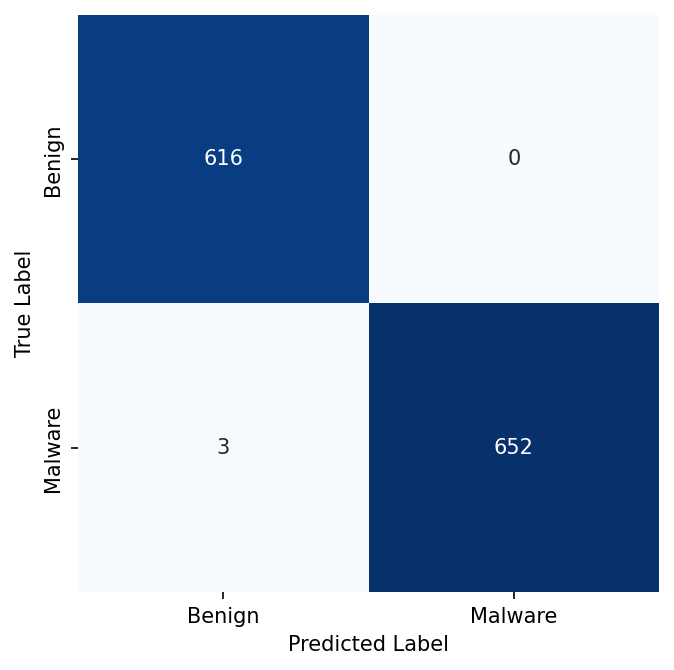

In [ ]:
# 🧪 Test set
y_pred_test = best_model.predict(x_test)
print("\n📊 Report sul test set:")
print("%d esatte previsioni su %d samples"% ((y_test == y_pred_test).sum(), x_test.shape[0]))
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test, normalize=None)
pyplot.figure(figsize=(5, 5), dpi = 150)
s = sns.heatmap(conf_matrix, cmap='Blues', annot=True, xticklabels=['Benign' , 'Malware'],
                yticklabels=['Benign' , 'Malware'], cbar=False, fmt='g')
s.set(xlabel='Predicted Label', ylabel='True Label')
print("Classification report\n %s" % (classification_report(y_test, y_pred_test)))

## Generalization set


📊 Valutazione finale su dataset2:
970 esatte previsioni su 1945 samples
✅ Accuracy su dataset2: 0.4987146529562982
✅ Recall su dataset2: 0.01616161616161616
Classification report
               precision    recall  f1-score   support

         0.0       0.49      1.00      0.66       955
         1.0       0.94      0.02      0.03       990

    accuracy                           0.50      1945
   macro avg       0.72      0.51      0.35      1945
weighted avg       0.72      0.50      0.34      1945



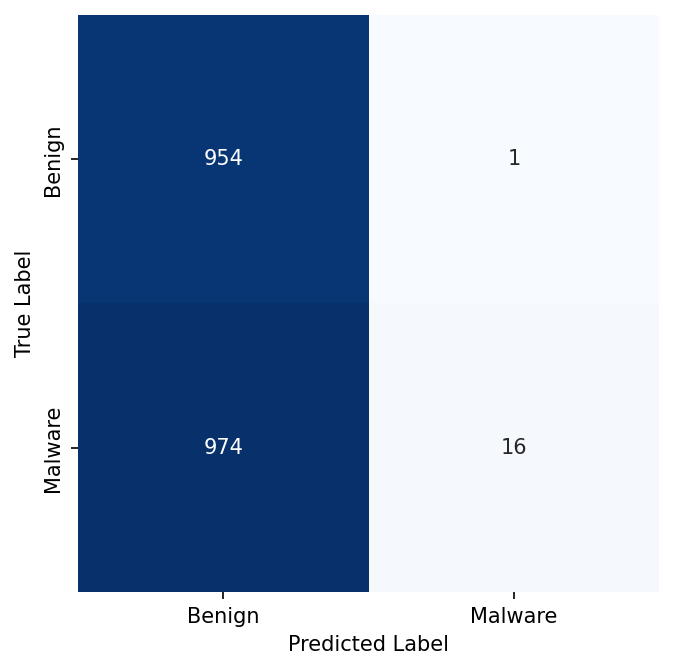

In [ ]:
# 🔵 Predizione su dataset2 con soglia normale (0.5)
y_pred_dataset2 = best_model.predict(x_dataset2)

print("\n📊 Valutazione finale su dataset2:")
print("%d esatte previsioni su %d samples"% ((y_dataset2 == y_pred_dataset2).sum(), x_dataset2.shape[0]))
print("✅ Accuracy su dataset2:", accuracy_score(y_dataset2, y_pred_dataset2))
print("✅ Recall su dataset2:", recall_score(y_dataset2, y_pred_dataset2))


conf_matrix = confusion_matrix(y_dataset2, y_pred_dataset2, normalize=None)
pyplot.figure(figsize=(5, 5), dpi = 150)
s = sns.heatmap(conf_matrix, cmap='Blues', annot=True, xticklabels=['Benign' , 'Malware'],
                yticklabels=['Benign' , 'Malware'], cbar=False, fmt='g')
s.set(xlabel='Predicted Label', ylabel='True Label')
print("Classification report\n %s" % (classification_report(y_dataset2, y_pred_dataset2)))

In [ ]:
import joblib

# Salvataggio del miglior modello
joblib.dump(best_model, '/content/drive/Shareddrives/AI for Cybersecurity/Consegna/ML Model/best_random_forest_model.pkl')
print("💾 Modello salvato come 'best_random_forest_model.pkl'")

💾 Modello salvato come 'best_random_forest_model.pkl'


In [ ]:
import joblib

# Caricamento del modello
best_model = joblib.load('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/ML Model/best_random_forest_model.pkl')
print("✅ Modello caricato!")

# Ora puoi usarlo direttamente per predire:
pred_val = best_model.predict(x_validation)
pred_test = best_model.predict(x_test)
print("Accuracy on validation set:", accuracy_score(y_validation, pred_val))
print("Accuracy on test set:", accuracy_score(y_test, pred_test))

✅ Modello caricato!
Accuracy on validation set: 0.9996078431372549
Accuracy on test set: 0.997639653815893


# Feature Analysis

In [ ]:
def get_json_features(path): #restituisce le feature in formato JSON (dizionario) anziché lista numerica
    extractor = PEFeatureExtractor(print_feature_warning=False)
    with open(path, 'rb') as f:
        bytes = f.read()
        return extractor.get_json_features(bytes)

import json
extractor = PEFeatureExtractor(print_feature_warning=False)
print( json.dumps(extractor.get_feature_range(), indent=4) ) #quali feature Ember estrae, suddivise per categoria, e quali indici occupano nel vettore finale.

{
    "histogram": [
        0,
        256
    ],
    "byte entropy": [
        256,
        512
    ],
    "strings": [
        512,
        616
    ],
    "general": [
        616,
        626
    ],
    "header": [
        626,
        688
    ],
    "section": [
        688,
        943
    ],
    "imports": [
        943,
        2223
    ],
    "exports": [
        2223,
        2351
    ],
    "data directories": [
        2351,
        2381
    ]
}


In [ ]:
import math
#Crea una lista di stringhe: ["feature_1", ..., "feature_2381"]
feature_names = ["feature_{}".format(i) for i in range(0,2381)]
#.feature_importances_ restituisce un array con l’importanza relativa di ogni feature. Somma totale = 1 (cioè le importanze sono normalizzate)
importances = best_model.feature_importances_
#Calcola la deviazione standard dell’importanza delle feature su tutti gli alberi
#Itera su tutti gli alberi (classifier.estimators_)
#Per ciascun albero prende le feature_importances_
#Calcola la deviazione standard std per ogni feature
#Utile per aggiungere barre d’errore nel grafico (± deviazione)
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)

#Crea una Series Pandas che collega ogni feature al suo valore di importanza
forest_importances = pd.Series(importances, index=feature_names)

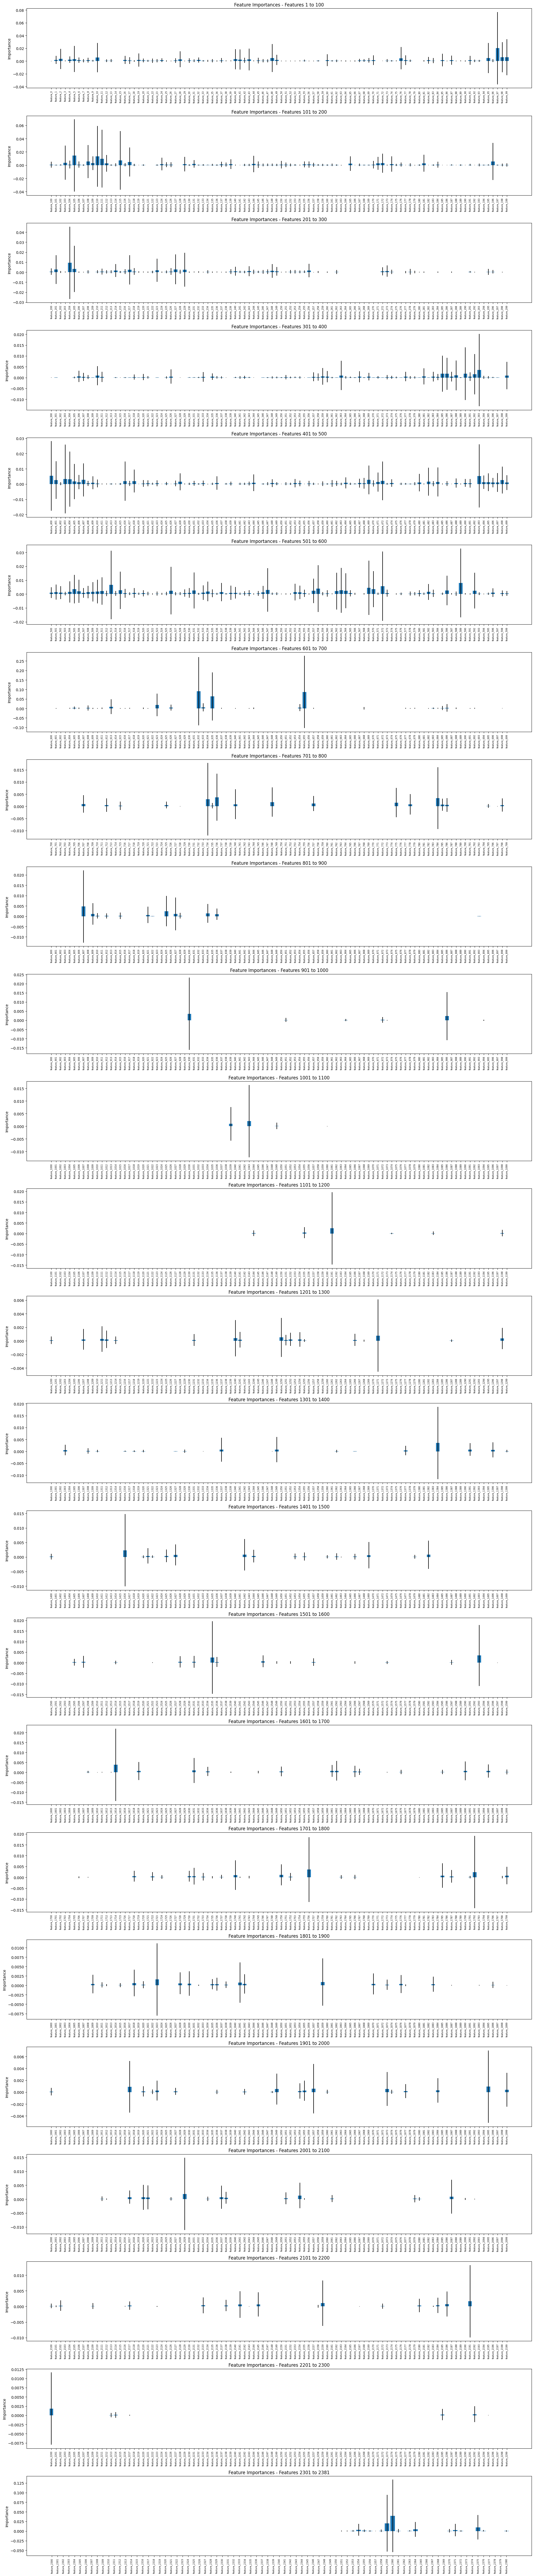

In [ ]:
# === GRAFICO 1: TUTTE LE FEATURE (divise ogni 100) ===
features_per_plot = 100
n_features = len(feature_names)
n_plots = math.ceil(n_features / features_per_plot)

fig, axes = plt.subplots(n_plots, 1, figsize=(20, n_plots * 4))
if n_plots == 1:
    axes = [axes]

for i in range(n_plots):
    start = i * features_per_plot
    end = min((i + 1) * features_per_plot, n_features)

    ax = axes[i]
    feature_subset = feature_names[start:end]
    importance_subset = importances[start:end]
    std_subset = std[start:end]

    ax.bar(feature_subset, importance_subset, yerr=std_subset)
    ax.set_title(f"Feature Importances - Features {start + 1} to {end}")
    ax.set_ylabel("Importance")
    ax.set_xticks(np.arange(len(feature_subset)))
    ax.set_xticklabels(feature_subset, rotation=90, fontsize=6)

plt.tight_layout()
plt.show()

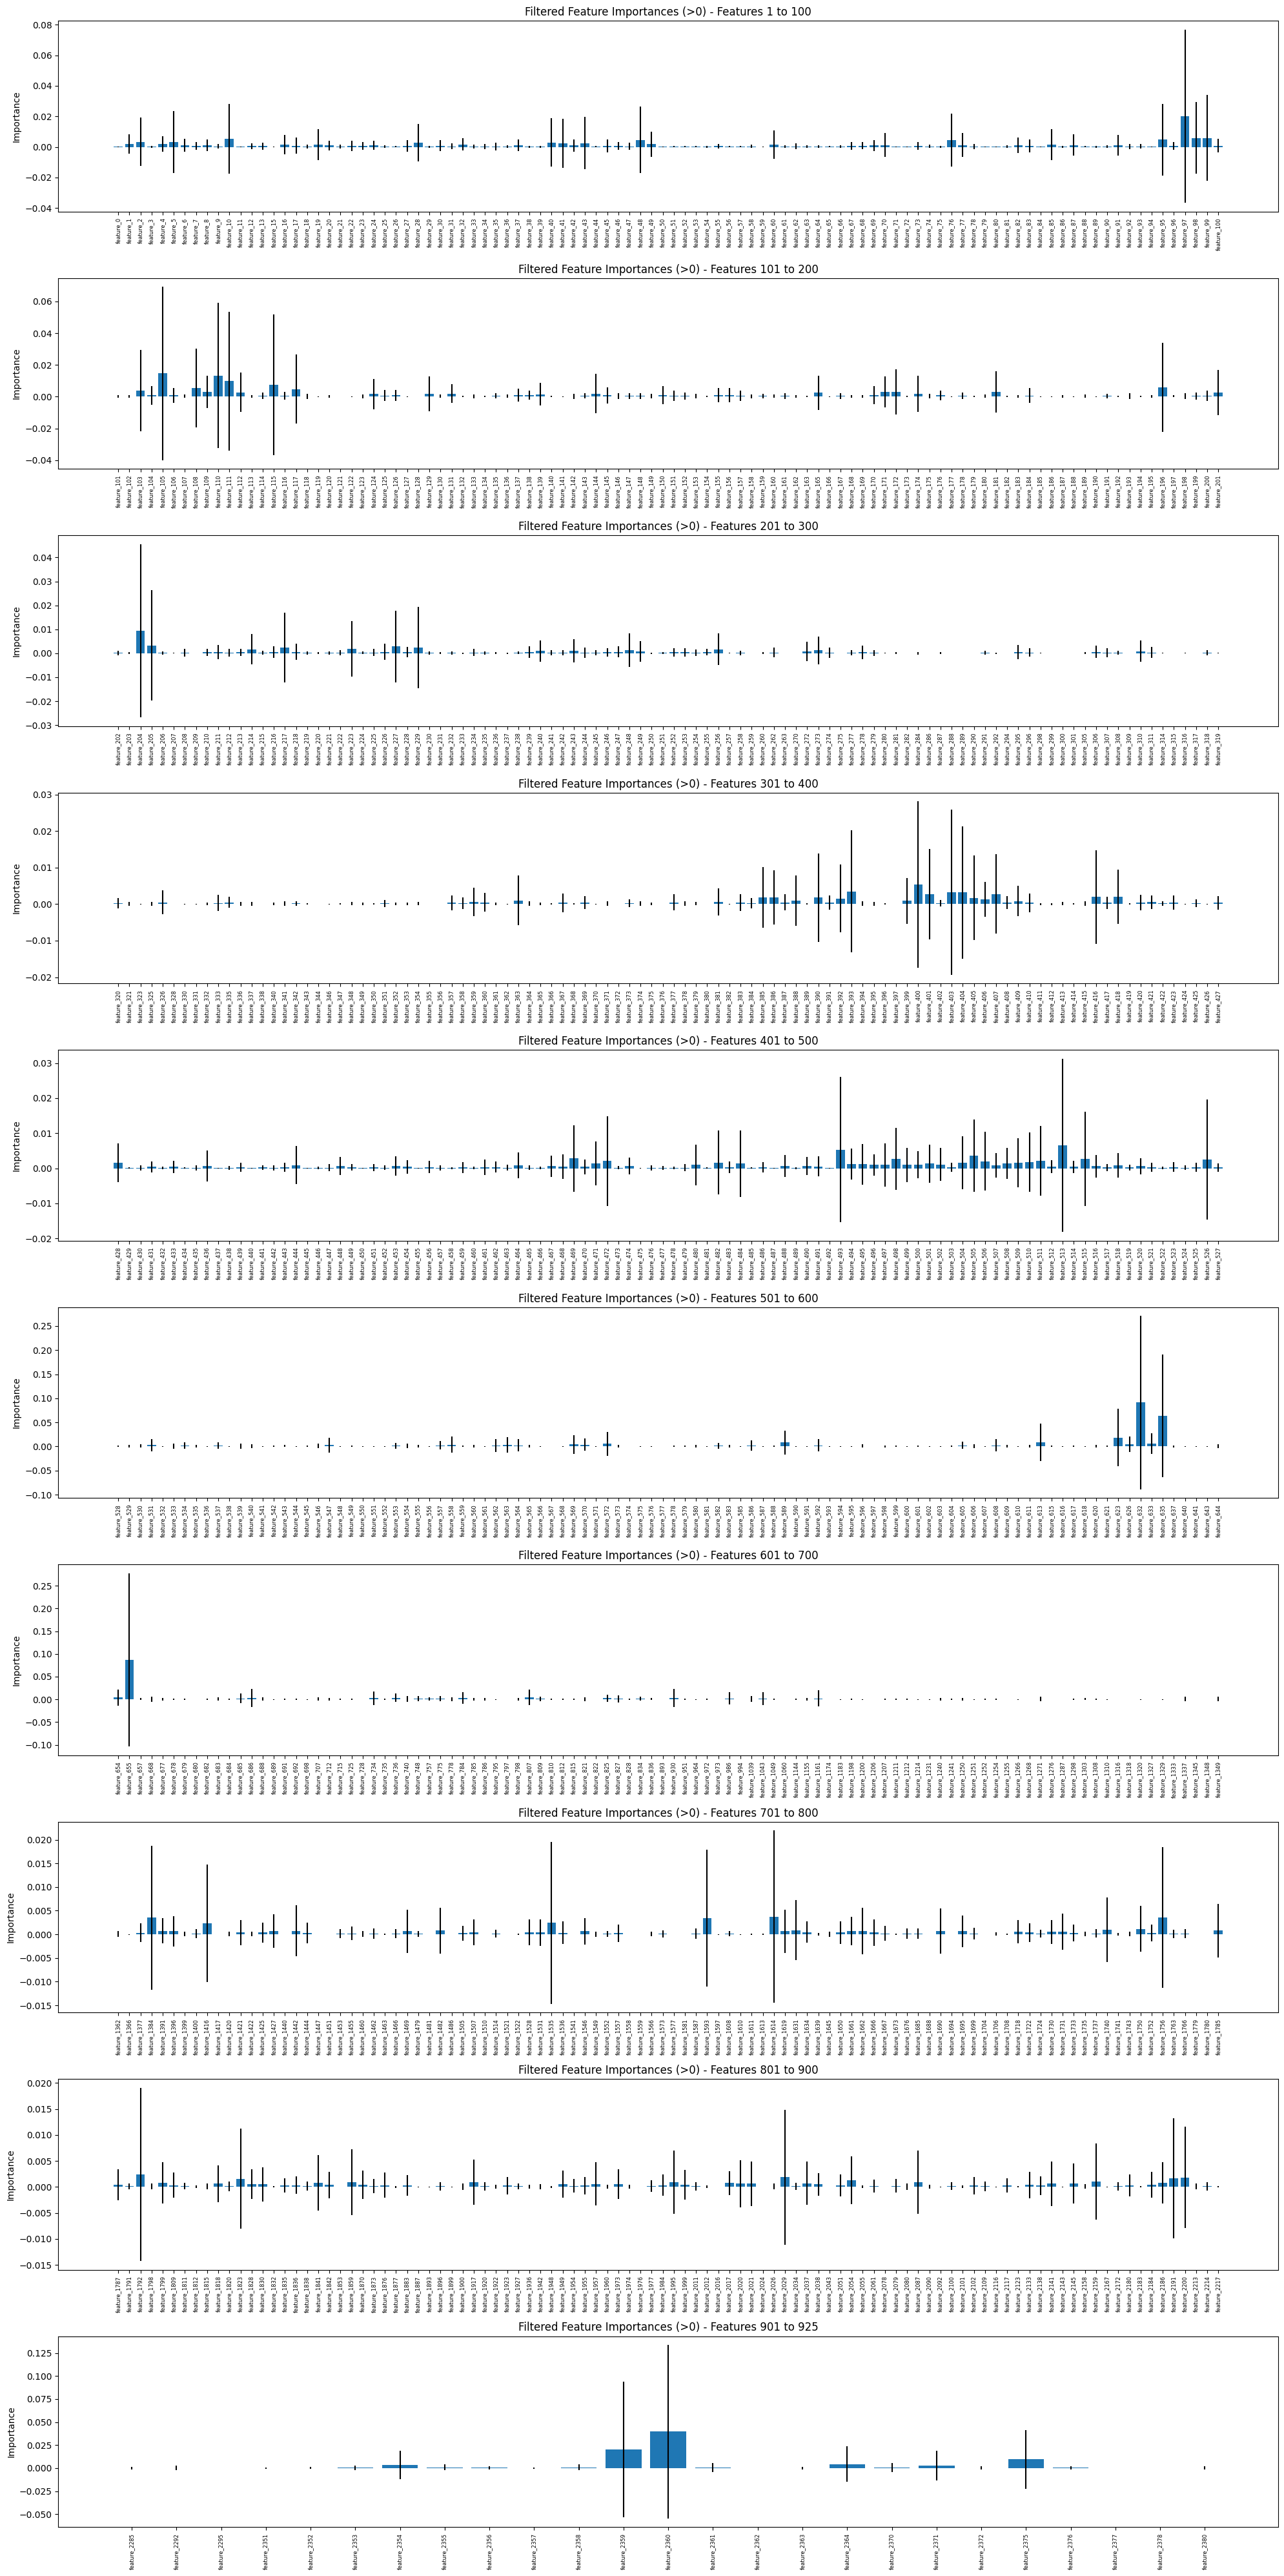

In [ ]:
# === GRAFICO 2: SOLO FEATURE CON IMPORTANZA > 0 ===
non_zero_indices = np.where(importances > 0)[0]
filtered_importances = importances[non_zero_indices]
filtered_std = std[non_zero_indices]
filtered_feature_names = [feature_names[i] for i in non_zero_indices]

features_per_plot = 100
n_features_filtered = len(filtered_feature_names)
n_plots_filtered = math.ceil(n_features_filtered / features_per_plot)

fig, axes = plt.subplots(n_plots_filtered, 1, figsize=(20, n_plots_filtered * 4))
if n_plots_filtered == 1:
    axes = [axes]

for i in range(n_plots_filtered):
    start = i * features_per_plot
    end = min((i + 1) * features_per_plot, n_features_filtered)

    ax = axes[i]
    feature_subset = filtered_feature_names[start:end]
    importance_subset = filtered_importances[start:end]
    std_subset = filtered_std[start:end]

    ax.bar(feature_subset, importance_subset, yerr=std_subset)
    ax.set_title(f"Filtered Feature Importances (>0) - Features {start + 1} to {end}")
    ax.set_ylabel("Importance")
    ax.set_xticks(np.arange(len(feature_subset)))
    ax.set_xticklabels(feature_subset, rotation=90, fontsize=6)

plt.tight_layout()
plt.show()

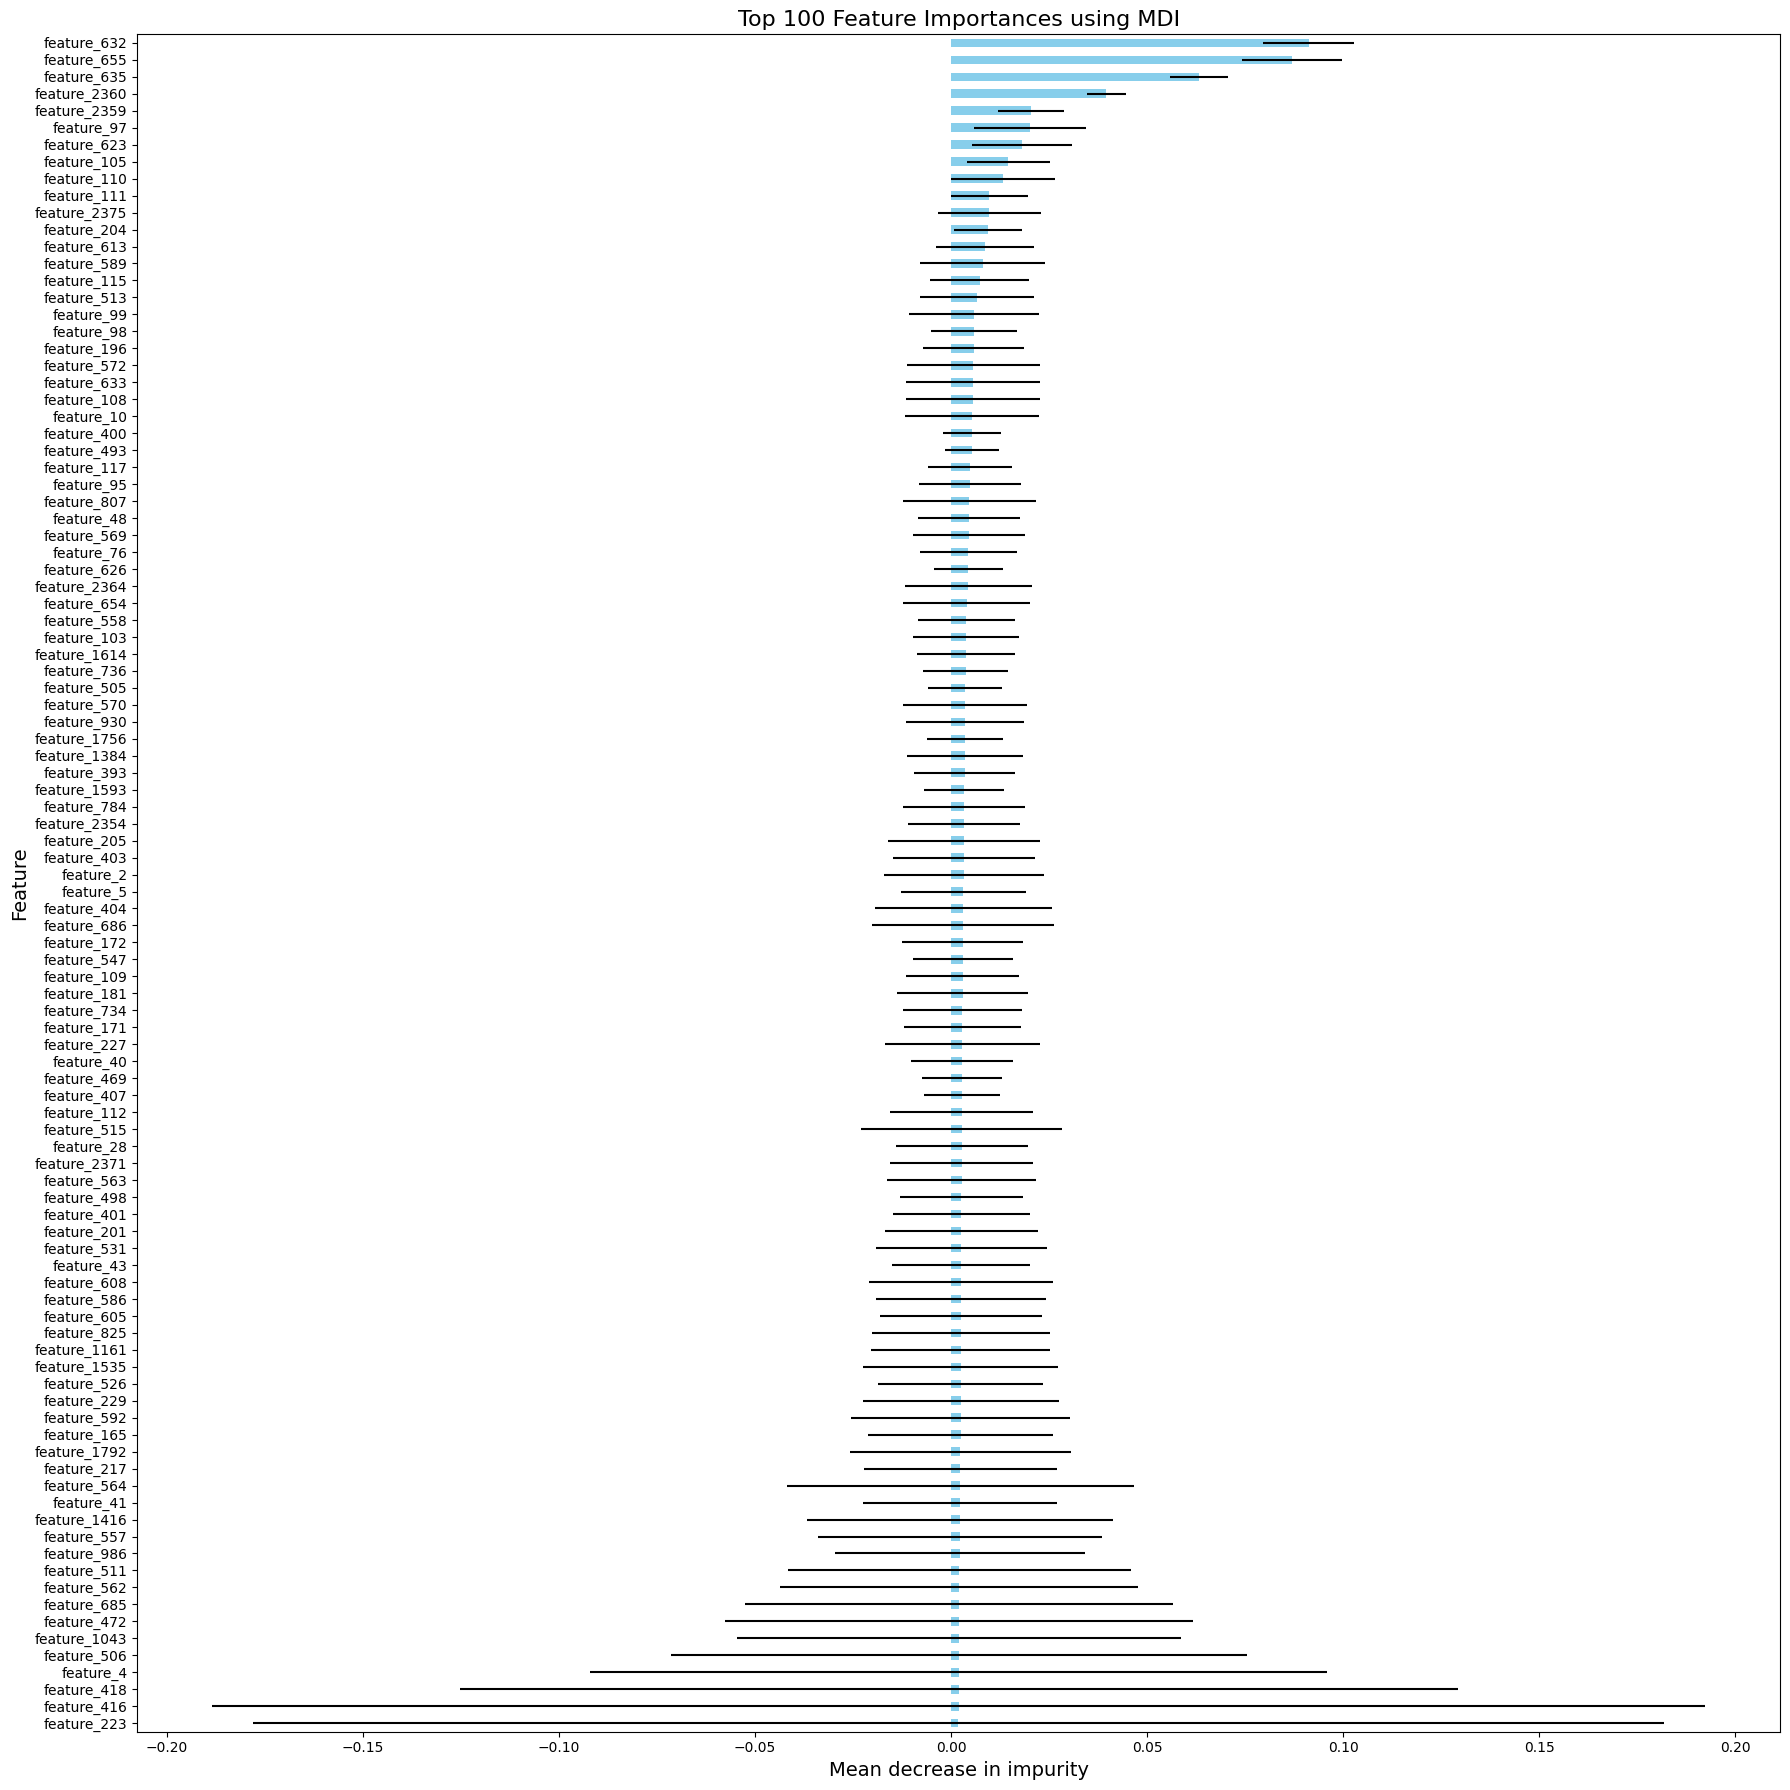

In [ ]:
# === GRAFICO 3: TOP 100 FEATURE ===
top_k = 100
top_features = forest_importances.sort_values(ascending=False).head(top_k)
top_feature_indices = [int(name.split("_")[1]) for name in top_features.index]
top_std = std[top_feature_indices]

# Grafico orizzontale con più spazio
fig, ax = plt.subplots(figsize=(18, 18))  # Altezza aumentata per leggibilità
top_features.sort_values().plot.barh(xerr=top_std, ax=ax, color="skyblue")

ax.set_title(f"Top {top_k} Feature Importances using MDI", fontsize=16)
ax.set_xlabel("Mean decrease in impurity", fontsize=14)
ax.set_ylabel("Feature", fontsize=14)
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()

## Categorizzazione delle features

In [ ]:
extractor = PEFeatureExtractor(print_feature_warning=False)

# get the feature range from EMBER feature extractor
categories = extractor.get_feature_range() # Ottiene un dizionario con gli intervalli di feature per ciascuna categoria (es. "header", "section",

# get the feature importance
feature_importances = best_model.feature_importances_

# Create a list of tuples (feature_index , feature_importance)
feature_importance_list = [(idx, importance) for idx, importance in enumerate(feature_importances)]

# sort the list dalla più importante alla meno importante
sorted_feature_importance = sorted(feature_importance_list, key=lambda x: x[1], reverse=True)

# print the list w.r.t. their importances
for rank, (feature_idx, importance) in enumerate(sorted_feature_importance, start=1):
    for category, (start, end) in categories.items():
        if start <= feature_idx < end:
            print(f"Rank {rank}: Feature {feature_idx} - Importance: {importance:.4f} - Category: {category}")
            break

Rank 1: Feature 632 - Importance: 0.0912 - Category: header
Rank 2: Feature 655 - Importance: 0.0870 - Category: header
Rank 3: Feature 635 - Importance: 0.0631 - Category: header
Rank 4: Feature 2360 - Importance: 0.0396 - Category: data directories
Rank 5: Feature 2359 - Importance: 0.0203 - Category: data directories
Rank 6: Feature 97 - Importance: 0.0201 - Category: histogram
Rank 7: Feature 623 - Importance: 0.0181 - Category: general
Rank 8: Feature 105 - Importance: 0.0146 - Category: histogram
Rank 9: Feature 110 - Importance: 0.0132 - Category: histogram
Rank 10: Feature 111 - Importance: 0.0098 - Category: histogram
Rank 11: Feature 2375 - Importance: 0.0097 - Category: data directories
Rank 12: Feature 204 - Importance: 0.0094 - Category: histogram
Rank 13: Feature 613 - Importance: 0.0087 - Category: strings
Rank 14: Feature 589 - Importance: 0.0080 - Category: strings
Rank 15: Feature 115 - Importance: 0.0073 - Category: histogram
Rank 16: Feature 513 - Importance: 0.0065

In [ ]:
# Valori delle feature da analizzare
feature_indices = [632, 655, 635, 2360, 2359, 97, 623, 105, 110]

def format_value(v):
    if isinstance(v, float):
        # Se il numero è un intero rappresentato come float, mostra come 0.0, 1.0, ecc.
        if v == int(v):
            return f"{v:.1f}"
        else:
            return f"{v:.5f}"
    else:
        return str(v)

# Stampa dei valori per i primi 10 malware
print("MALWARE FEATURES:\n")
for idx in range(10):
    values = [training_malware_features[idx][i] for i in feature_indices]
    formatted_values = [format_value(v) for v in values]
    print(f"Malware {idx + 1}: [{', '.join(formatted_values)}]")

# Stampa dei valori per i primi 10 benigni
print("\nBENIGN FEATURES:\n")
for idx in range(10):
    values = [training_benign_features[idx][i] for i in feature_indices]
    formatted_values = [format_value(v) for v in values]
    print(f"Benigno {idx + 1}: [{', '.join(formatted_values)}]")

MALWARE FEATURES:

Malware 1: [0.0, 1.0, 1.0, 0.0, 0.0, 0.00273, 0.0, 0.00248, 0.00264]
Malware 2: [0.0, 1.0, 1.0, 0.0, 0.0, 0.00294, 0.0, 0.00252, 0.00298]
Malware 3: [0.0, 1.0, 1.0, 0.0, 0.0, 0.00559, 0.0, 0.00407, 0.00353]
Malware 4: [0.0, 1.0, 1.0, 0.0, 0.0, 0.00183, 0.0, 0.00170, 0.00165]
Malware 5: [0.0, 1.0, 1.0, 0.0, 0.0, 0.00394, 0.0, 0.00391, 0.00380]
Malware 6: [0.0, 1.0, 1.0, 0.0, 0.0, 0.00114, 0.0, 0.00117, 0.00093]
Malware 7: [0.0, 1.0, 1.0, 0.0, 0.0, 0.00294, 0.0, 0.00252, 0.00299]
Malware 8: [0.0, 1.0, 1.0, 0.0, 0.0, 0.00182, 0.0, 0.00160, 0.00182]
Malware 9: [0.0, 1.0, 1.0, 0.0, 0.0, 0.00114, 0.0, 0.00117, 0.00093]
Malware 10: [0.0, 1.0, 1.0, 0.0, 0.0, 0.00302, 0.0, 0.00237, 0.00439]

BENIGN FEATURES:

Benigno 1: [1.0, -1.0, 0.0, 140784.0, 6688.0, 0.01589, 1.0, 0.00936, 0.00897]
Benigno 2: [1.0, -1.0, 0.0, 0.0, 0.0, 0.00596, 0.0, 0.00462, 0.00514]
Benigno 3: [1.0, 0.0, 0.0, 169472.0, 6328.0, 0.00461, 1.0, 0.00516, 0.00480]
Benigno 4: [1.0, -1.0, 0.0, 0.0, 0.0, 0.00395,

In [ ]:
# Valori delle feature da analizzare
feature_indices = [632, 655, 635, 2360, 2359, 97, 623, 105, 110]

def format_value(v):
    if isinstance(v, float):
        # Se il numero è un intero rappresentato come float, mostra come 0.0, 1.0, ecc.
        if v == int(v):
            return f"{v:.1f}"
        else:
            return f"{v:.5f}"
    else:
        return str(v)

# Stampa dei valori per i primi 10 malware
print("MALWARE FEATURES:\n")
for idx in range(10):
    values = [dataset2_malware_features[idx][i] for i in feature_indices]
    formatted_values = [format_value(v) for v in values]
    print(f"Malware {idx + 1}: [{', '.join(formatted_values)}]")

# Stampa dei valori per i primi 10 benigni
print("\nBENIGN FEATURES:\n")
for idx in range(10):
    values = [dataset2_benign_features[idx][i] for i in feature_indices]
    formatted_values = [format_value(v) for v in values]
    print(f"Benigno {idx + 1}: [{', '.join(formatted_values)}]")

MALWARE FEATURES:

Malware 1: [1.0, 0.0, 0.0, 1884160.0, 7432.0, 0.00845, 1.0, 0.00815, 0.00770]
Malware 2: [1.0, 0.0, 0.0, 24576.0, 9224.0, 0.00511, 1.0, 0.00544, 0.00503]
Malware 3: [1.0, -1.0, 0.0, 0.0, 0.0, 0.00351, 0.0, 0.00358, 0.00355]
Malware 4: [1.0, 0.0, 0.0, 0.0, 0.0, 0.00386, 0.0, 0.00410, 0.00370]
Malware 5: [1.0, -1.0, 0.0, 0.0, 0.0, 0.00288, 0.0, 0.00248, 0.00277]
Malware 6: [1.0, -1.0, 0.0, 0.0, 0.0, 0.00367, 0.0, 0.00368, 0.00365]
Malware 7: [1.0, 0.0, 0.0, 0.0, 0.0, 0.00412, 0.0, 0.00392, 0.00386]
Malware 8: [1.0, -1.0, 0.0, 0.0, 0.0, 0.00393, 0.0, 0.00390, 0.00392]
Malware 9: [1.0, -1.0, 0.0, 0.0, 0.0, 0.00616, 0.0, 0.00814, 0.00707]
Malware 10: [1.0, -1.0, 0.0, 56832.0, 14240.0, 0.00519, 1.0, 0.00712, 0.00626]

BENIGN FEATURES:

Benigno 1: [0.0, -1.0, 0.0, 135168.0, 9976.0, 0.00163, 1.0, 0.00216, 0.00162]
Benigno 2: [1.0, 0.0, 0.0, 0.0, 0.0, 0.02837, 0.0, 0.03301, 0.03747]
Benigno 3: [1.0, 0.0, 0.0, 0.0, 0.0, 0.01223, 0.0, 0.01003, 0.00966]
Benigno 4: [1.0, 0.0, 0.0

## Stampa Header Features

In [ ]:
import random
import os

with open(os.path.join('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/malware', random.choice(os.listdir('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/malware'))), 'rb') as f:
    bytes = f.read()

#Ottiene l’indice iniziale delle feature appartenenti alla categoria “header” (tra tutte le feature del vettore EMBER).
starting_value_header = extractor.get_feature_range()['header'][0]
#Estrae l’indice relativo alle feature specifiche dell'header PE contenute in quel file.
rv = extractor.get_header_features_index(bytes)

print("HEADER")
for key in rv:
  if type(rv[key]) == tuple: #Alcune feature coprono un range di indici (es. coff-characteristics: (11, 21)), quindi sono tuple (inizio, fine).
    print(f'{key}: {rv[key][0] + starting_value_header} - {rv[key][1] + starting_value_header}')
  else:
    print(f'{key}: {rv[key] + starting_value_header}') #Altre sono singole (es. coff-timestamp: 0)
#dall'output puoi notare che 632, 635 parte di coff-machine

Export.NumberOfNamePointers is too large (3503608079)
''US3(uio+_' is not a valid DLL name and will be discarded


HEADER
coff-timestamp: 626
coff-machine: 627 - 637
coff-characteristics: 637 - 647
optional-subsystem: 647 - 657
optional-dll_characteristics: 657 - 667
optional-magic: 667 - 677
optional-major_image_version: 677
optional-minor_image_version: 678
optional-major_linker_version: 679
optional-minor_linker_version: 680
optional-major_operating_system_version: 681
optional-minor_operating_system_version: 682
optional-major_subsystem_version: 683
optional-minor_subsystem_version: 684
optional-sizeof_code: 685
optional-sizeof_headers: 686
optional-sizeof_heap_commit: 687


### Features 632, 635 (coff.machine) e 655 (optional.subsystem)

In [ ]:
from ember.features import PEFeatureExtractor
import os

malware_dir = "/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/malware"
extractor = PEFeatureExtractor(print_feature_warning=False)
features_to_extract = ["coff.machine","optional.subsystem"]
category = "malware"

count = 0
for file_name in os.listdir(malware_dir):
  file_path = os.path.join(malware_dir, file_name)
  with open(file_path, 'rb') as file:
      raw, _ = extractor.get_raw_and_processed_features(file.read(), 'header')

  print(f"File ({category}): {file_name}")
  for key_path in features_to_extract:
      try:
          parts = key_path.split('.')
          value = raw
          for part in parts:
              value = value[part]
          print(f"\t{key_path}: {value}")
      except KeyError:
          print(f"\t{key_path}: [KEY NOT FOUND]")
  print()
  count += 1
  if count >= 5:
      break

File (malware): 33ca40e533b01144252c93798839bb5519f5030c99ad93d954ad9c8e256f09d9
	coff.machine: UNKNOWN
	optional.subsystem: UNKNOWN

File (malware): 9ce8cddd53eb41425163a5daf21bbb62d3df83287ad99e6f33e1cdb0a883188e
	coff.machine: UNKNOWN
	optional.subsystem: UNKNOWN

File (malware): 631bc90de79ac0a65812a6fa4889bf03185ee1f92370db86a22f63bbb875b0e4
	coff.machine: UNKNOWN
	optional.subsystem: UNKNOWN

File (malware): 8da703a70be8e5ef4ab624d1dd6f0a69b16ffcbb853011fbdb3ebbf5c937efdc
	coff.machine: UNKNOWN
	optional.subsystem: UNKNOWN

File (malware): 393304fde3e5f36cfd3c3c56fd9fb8515088de3b45e1d0d6133e8c4f21ea2419
	coff.machine: UNKNOWN
	optional.subsystem: UNKNOWN



In [ ]:
from ember.features import PEFeatureExtractor
import os

benign_dir = "/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/benign"
extractor = PEFeatureExtractor(print_feature_warning=False)
features_to_extract = ["coff.machine","optional.subsystem"]
category = "benign"

count = 0
for file_name in os.listdir(benign_dir):
  file_path = os.path.join(benign_dir, file_name)
  with open(file_path, 'rb') as file:
      raw, _ = extractor.get_raw_and_processed_features(file.read(), 'header')

  print(f"File ({category}): {file_name}")
  for key_path in features_to_extract:
      try:
          parts = key_path.split('.')
          value = raw
          for part in parts:
              value = value[part]
          print(f"\t{key_path}: {value}")
      except KeyError:
          print(f"\t{key_path}: [KEY NOT FOUND]")
  print()
  count += 1
  if count >= 5:
      break

File (benign): b039bc8a626729101420967f70f6ef8469b47b3a1357f14271b44a086338bf9e
	coff.machine: AMD64
	optional.subsystem: WINDOWS_CUI

File (benign): b01afda35fe7ae222b1a5cb58d7a061c566904e6d53858b7f9ae76e3cd73dc03
	coff.machine: AMD64
	optional.subsystem: WINDOWS_CUI

File (benign): f4bfec3ba96c1d1c8fc6d646f9a13872d4cb14b1fbd9fb3dbd37379160e83287
	coff.machine: AMD64
	optional.subsystem: WINDOWS_CUI

File (benign): 1a0b917d701bae3277ba654f602976dd7720d5f993a54f3c2efc073a6a44a92d
	coff.machine: I386
	optional.subsystem: WINDOWS_GUI

File (benign): 0f089f8a29745b24daa48139e713df7b0e2290a4ff03a598d639927166451327
	coff.machine: AMD64
	optional.subsystem: WINDOWS_CUI



## Stampa Data Directories Features

In [ ]:
import random
import os
import json
extractor=PEFeatureExtractor(print_feature_warning=False)
# Legge un file casuale dalla cartella decompressed
with open(os.path.join('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/malware', random.choice(os.listdir('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/malware'))), 'rb') as f:
    bytes = f.read()
rv={}

# Stampa l'intervallo delle feature
print(extractor.get_feature_range())

# Ottiene il valore iniziale per le feature della categoria "Data directories"
starting_value = extractor.get_feature_range()['data directories'][0]

# Estrai le feature raw e prendi le chiavi
rv = extractor.raw_features(bytes)['datadirectories']

for r in rv:
    rvKeys = r.keys()
    # Itera sulle feature per calcolarne l'intervallo
    for key in rvKeys:
     if isinstance(r[key], list):
        print(f'{key}: {r[key]} {starting_value} - {len(rv[key]) + starting_value}')
        starting_value += len(r[key])
     else:
        print(f'{key}: {r[key]} {starting_value}')
        starting_value += 1

{'histogram': (0, 256), 'byte entropy': (256, 512), 'strings': (512, 616), 'general': (616, 626), 'header': (626, 688), 'section': (688, 943), 'imports': (943, 2223), 'exports': (2223, 2351), 'data directories': (2351, 2381)}
name: TYPES.EXPORT_TABLE 2351
size: 0 2352
virtual_address: 0 2353
name: TYPES.IMPORT_TABLE 2354
size: 944 2355
virtual_address: 730648 2356
name: TYPES.RESOURCE_TABLE 2357
size: 1560 2358
virtual_address: 729088 2359
name: TYPES.EXCEPTION_TABLE 2360
size: 0 2361
virtual_address: 0 2362
name: TYPES.CERTIFICATE_TABLE 2363
size: 0 2364
virtual_address: 0 2365
name: TYPES.BASE_RELOCATION_TABLE 2366
size: 0 2367
virtual_address: 0 2368
name: TYPES.DEBUG_DIR 2369
size: 0 2370
virtual_address: 0 2371
name: TYPES.ARCHITECTURE 2372
size: 0 2373
virtual_address: 0 2374
name: TYPES.GLOBAL_PTR 2375
size: 0 2376
virtual_address: 0 2377
name: TYPES.TLS_TABLE 2378
size: 0 2379
virtual_address: 0 2380
name: TYPES.LOAD_CONFIG_TABLE 2381
size: 0 2382
virtual_address: 0 2383
name: 

### Features 2359 e 2360

In [ ]:
i = 0
j = 0

print("Malware:")
for vector in training_malware_features:
    if vector[2360] != 0:
        i += 1
    else:
        j += 1

print("sum(0):", j)
print("sum(!=0):", i)

i = 0
j = 0

print("\nBenigni:")
for vector in training_benign_features:
    if vector[2360] != 0:
        i += 1
    else:
        j += 1

print("sum(0):", j)
print("sum(!=0):", i)

Malware:
sum(0): 4379
sum(!=0): 212

Benigni:
sum(0): 2104
sum(!=0): 2272


In [ ]:
import os
from ember.features import PEFeatureExtractor

# Inizializzazione estrattore
extractor = PEFeatureExtractor(print_feature_warning=False)

# Percorsi ai file
malware_dir = "/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/malware"
benign_dir = "/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/benign"

def stampa_features_datadirectories(path, categoria):
    print(f"\n📂 Analisi primi 5 file {categoria}:")
    count = 0
    for filename in sorted(os.listdir(path)):
        if count >= 300:
            break
        try:
            with open(os.path.join(path, filename), "rb") as f:
                raw_features = extractor.raw_features(f.read())
                dd = raw_features["datadirectories"]
                print(f"{count+1:02d}) File: {filename}")
                print(f"   Feature 2359 - ExceptionTable.virtual_address: {dd[1]['virtual_address']}")
                print(f"   Feature 2360 - ExceptionTable.size:           {dd[1]['size']}")
                count += 1
        except Exception as e:
            print(f"⚠️ Errore nel file {filename}: {e}")
            continue

# Analizza i primi 5 file malware e benigni
stampa_features_datadirectories(malware_dir, "malware")
stampa_features_datadirectories(benign_dir, "benigni")



📂 Analisi primi 5 file malware:


Unable to find the section associated with BOUND_IMPORT


01) File: 0008e8527f02041c663a46be1bd4008f6689b979175a71378f0a932719abbf84
   Feature 2359 - ExceptionTable.virtual_address: 48776
   Feature 2360 - ExceptionTable.size:           200
02) File: 000b0f559dac4563a81c8563c7ab88d98d176b134c52f784da74e33b646823f5
   Feature 2359 - ExceptionTable.virtual_address: 730648
   Feature 2360 - ExceptionTable.size:           944


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


03) File: 0019564e24f1c8e174afa62539adc841909100df290687fb02bc1be893eecb41
   Feature 2359 - ExceptionTable.virtual_address: 28868
   Feature 2360 - ExceptionTable.size:           100
04) File: 002491b02d6cf285910d515d11c9c90c69bd7bd5603ada50e7ec41cccbe89db1
   Feature 2359 - ExceptionTable.virtual_address: 12540
   Feature 2360 - ExceptionTable.size:           140
05) File: 0029c6d188edb207357c66cc5035c2f02b79307ca472ce14a3a8488382a8a72b
   Feature 2359 - ExceptionTable.virtual_address: 461652
   Feature 2360 - ExceptionTable.size:           280
06) File: 002d9528055c92c2d702ad63fa4fce6fafe4bc0968f5a50f25f73ab2e8955b47
   Feature 2359 - ExceptionTable.virtual_address: 191892
   Feature 2360 - ExceptionTable.size:           320
07) File: 002fa3f12e2a68f20fdc360382455bcddba8eef7de57d6701a6589388fc389b9
   Feature 2359 - ExceptionTable.virtual_address: 86016
   Feature 2360 - ExceptionTable.size:           2148
08) File: 0037087667513a283de573ef1ff2e3d89e42a73c0dfa4f687568e79f929e0253
  

Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


09) File: 003af70f4660a185035a93bc133ab1bfe1288007bf00aad7cb115009d1b301df
   Feature 2359 - ExceptionTable.virtual_address: 28868
   Feature 2360 - ExceptionTable.size:           100
10) File: 004025016eea7ce4df0a3b0fca51560e7334904e6c4a09f2d43f4be02efd38cb
   Feature 2359 - ExceptionTable.virtual_address: 45056
   Feature 2360 - ExceptionTable.size:           2276
11) File: 0042c1c5925719f93e27059573cdcc76284b3df502bd6a3235a4b40ee42132a9
   Feature 2359 - ExceptionTable.virtual_address: 12944
   Feature 2360 - ExceptionTable.size:           180
12) File: 004661006e3efbc583e00b8d1c3650123a5096dd37e273538e22fb12f6d87894
   Feature 2359 - ExceptionTable.virtual_address: 86016
   Feature 2360 - ExceptionTable.size:           2148


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


13) File: 0055a8f219ab0fb69872d0b74c461eb2edd3722c080dbf4d1a7a2c285f150f36
   Feature 2359 - ExceptionTable.virtual_address: 28868
   Feature 2360 - ExceptionTable.size:           100
14) File: 00795104f68baf68b5a2763b6c7c403b11911c35a5c8ae676d81d28de37487fe
   Feature 2359 - ExceptionTable.virtual_address: 643072
   Feature 2360 - ExceptionTable.size:           16704
15) File: 0080573f758273e1dd11f7fea116e10576204abef2b288a926fc1e2f5c233ed3
   Feature 2359 - ExceptionTable.virtual_address: 2538796
   Feature 2360 - ExceptionTable.size:           140
16) File: 0090126879b25bbce8725214bc65327ffc9dec91efadd4adf4cc701a94d8df09
   Feature 2359 - ExceptionTable.virtual_address: 45056
   Feature 2360 - ExceptionTable.size:           2276


Can't read the padding content of section '.rsrc'
Unable to find the section associated with BOUND_IMPORT


17) File: 0092907573c85857639801b24d87b4e49b5ef5449edb6543ed30469aeb720f27
   Feature 2359 - ExceptionTable.virtual_address: 22728
   Feature 2360 - ExceptionTable.size:           220
18) File: 00a0cc71237d2598fdcb7b4fac86da0a1faf04803f5ed0d1b39bc3dd652fc7b9
   Feature 2359 - ExceptionTable.virtual_address: 27124
   Feature 2360 - ExceptionTable.size:           140
19) File: 00a14616e1ab1ffec045fce6c3d5f319d30ce0f0eef4714fb982ef03a39dc9a8
   Feature 2359 - ExceptionTable.virtual_address: 12944
   Feature 2360 - ExceptionTable.size:           180
20) File: 00ae0b9b2f41d9a79694b44b76a279ab9e7f758bb7d41eb44e5d770117053420
   Feature 2359 - ExceptionTable.virtual_address: 21304
   Feature 2360 - ExceptionTable.size:           260
21) File: 00b2cb97404586e429790e606a93ed5b1852feb8df86e33fb0e8c996cc1ec542
   Feature 2359 - ExceptionTable.virtual_address: 461652
   Feature 2360 - ExceptionTable.size:           280
22) File: 00b4efa33f59701c8cb24b0a4c36346c94d1b43376665f8b312265b6425a019f
   F

Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


29) File: 00d5d59ff1e8ddd4c6ac9832967fcaf27928274be009baf1faaa3f3bfa74deb1
   Feature 2359 - ExceptionTable.virtual_address: 28868
   Feature 2360 - ExceptionTable.size:           100
30) File: 00dd6eba6014c95c6425c17e84666cfcdd8cec4f8fee56dc8edb939542b9d595
   Feature 2359 - ExceptionTable.virtual_address: 27124
   Feature 2360 - ExceptionTable.size:           140
31) File: 00e20e3b72eeb04a46102ab3b36762265d4e6741ec8688d7677d688e81b2b13b
   Feature 2359 - ExceptionTable.virtual_address: 2498560
   Feature 2360 - ExceptionTable.size:           14708
32) File: 00e6316d496975f379f22719e8a202ff560e369bd3e027cf327b432a2d976287
   Feature 2359 - ExceptionTable.virtual_address: 2646016
   Feature 2360 - ExceptionTable.size:           14998


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


33) File: 00ec9277d40bcb353fcf090104584a3562434cb488e7f769bbe16a5dca55e9bd
   Feature 2359 - ExceptionTable.virtual_address: 28868
   Feature 2360 - ExceptionTable.size:           100


Export.AddressTableEntries is too large (1958551965)


34) File: 00fbea8603cc23e53bce323485a9e55ab5cc3f888ef9fa4dbdc2786692e9e54c
   Feature 2359 - ExceptionTable.virtual_address: 10704664
   Feature 2360 - ExceptionTable.size:           860
35) File: 0102ba4fcbc2be7a299f407f0f89aa8cd3f398809e0bd8ff9a9ff86ef247f990
   Feature 2359 - ExceptionTable.virtual_address: 461652
   Feature 2360 - ExceptionTable.size:           280


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


36) File: 0104186bfbb001359efe460025f59f65a79794d1699d430592c021bbcd9eae09
   Feature 2359 - ExceptionTable.virtual_address: 28868
   Feature 2360 - ExceptionTable.size:           100
37) File: 0108edb17b01c0364498b0bf0599f52abc60f49bc525625414538414e6f5368c
   Feature 2359 - ExceptionTable.virtual_address: 461652
   Feature 2360 - ExceptionTable.size:           280
38) File: 010c7bd9fef25227e779f4e4e5e91c30a7ae728c2bfe88ca5d8f55f5a41cd3a2
   Feature 2359 - ExceptionTable.virtual_address: 40960
   Feature 2360 - ExceptionTable.size:           2064
39) File: 0114d0854d061715ae8f3bc53ff6dc4e27edf7730fdcb00c9f9fb0ec88d5da44
   Feature 2359 - ExceptionTable.virtual_address: 376832
   Feature 2360 - ExceptionTable.size:           7095
40) File: 011518b58379d986a4fad32065db413516b5ad561bab9a377f96bce6e13cbdfd
   Feature 2359 - ExceptionTable.virtual_address: 1113032
   Feature 2360 - ExceptionTable.size:           160


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


41) File: 011e8217fee14711196541c2ffd169b971f8b28839e64a275a31d8b916700e21
   Feature 2359 - ExceptionTable.virtual_address: 28868
   Feature 2360 - ExceptionTable.size:           100
42) File: 0125ad5d8b6e9c21025616ebc9ce100048714b42c682eb494e6ec3816d856403
   Feature 2359 - ExceptionTable.virtual_address: 50916
   Feature 2360 - ExceptionTable.size:           80
43) File: 01273a3ebf22bbf13c5998f4d8ffedd666d3e7bd8d9e79428f34a55fb8288ea3
   Feature 2359 - ExceptionTable.virtual_address: 45056
   Feature 2360 - ExceptionTable.size:           2276
44) File: 01311b176438e697f482d5e623af8db10ab71a35d2d5a5a72056cc8d0bc4f456
   Feature 2359 - ExceptionTable.virtual_address: 730648
   Feature 2360 - ExceptionTable.size:           944
45) File: 01328b93b3bb381ca6b3a5bb6aff6624742040e9f58a42c181c59d473ee74414
   Feature 2359 - ExceptionTable.virtual_address: 407724
   Feature 2360 - ExceptionTable.size:           40
46) File: 013976e93c8a535b3b6e40ed49c9d4b1b18ce5e608984b547389a7b6610590cb
   F

## Stampa Histogram Features

In [ ]:
import random
import os
import json
extractor = PEFeatureExtractor(print_feature_warning=False)

# Leggi un file casuale dalla cartella
file_path = os.path.join('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/malware',
                         random.choice(os.listdir('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/malware')))
with open(file_path, 'rb') as f:
    bytes_data = f.read()

# Range delle feature
feature_range = extractor.get_feature_range()
print("Feature ranges:", feature_range)

# Ottieni histogram
histogram = extractor.raw_features(bytes_data)['histogram']

# Prendi il valore iniziale
starting_value = feature_range['histogram'][0]

# Scorri correttamente con enumerate
for i, value in enumerate(histogram):
    print(f'Byte value {i}: count {value} --> Feature index {starting_value + i}')

Feature ranges: {'histogram': (0, 256), 'byte entropy': (256, 512), 'strings': (512, 616), 'general': (616, 626), 'header': (626, 688), 'section': (688, 943), 'imports': (943, 2223), 'exports': (2223, 2351), 'data directories': (2351, 2381)}
Byte value 0: count 82175 --> Feature index 0
Byte value 1: count 5629 --> Feature index 1
Byte value 2: count 3367 --> Feature index 2
Byte value 3: count 3604 --> Feature index 3
Byte value 4: count 4821 --> Feature index 4
Byte value 5: count 1718 --> Feature index 5
Byte value 6: count 2146 --> Feature index 6
Byte value 7: count 2226 --> Feature index 7
Byte value 8: count 6189 --> Feature index 8
Byte value 9: count 1178 --> Feature index 9
Byte value 10: count 1074 --> Feature index 10
Byte value 11: count 1104 --> Feature index 11
Byte value 12: count 4236 --> Feature index 12
Byte value 13: count 1066 --> Feature index 13
Byte value 14: count 838 --> Feature index 14
Byte value 15: count 5694 --> Feature index 15
Byte value 16: count 3150 

## Stampa general Features

In [ ]:
def print_feature_key_ranges_from_dir(folder_path, category='general'):
    """
    Select a random file from a directory and print feature key ranges of a specified category.

    Parameters:
    - folder_path (str): Directory containing PE files.
    - category (str): Feature category ('general', 'header', 'section', etc.).
    """
    files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    if not files:
        print(f"No files found in folder: {folder_path}")
        return

    random_file = random.choice(files)
    file_path = os.path.join(folder_path, random_file)

    print(f"\nSelected file: {random_file}")

    extractor = PEFeatureExtractor()
    with open(file_path, 'rb') as f:
        bytes_data = f.read()

    try:
        start_index = extractor.get_feature_range()[category][0]
    except KeyError:
        print(f"Category '{category}' not found. Available categories: {list(extractor.get_feature_range().keys())}")
        return

    raw_features = extractor.get_raw_and_processed_features(bytes_data, category)[0]

    for key in raw_features:
        if isinstance(raw_features[key], list):
            print(f'{key}: {start_index} - {start_index + len(raw_features[key]) - 1}')
            start_index += len(raw_features[key])
        else:
            print(f'{key}: {start_index}')
            start_index += 1

print_feature_key_ranges_from_dir('/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/malware', category='general')


Selected file: 5d171957990bf32d28c00d4bdeadd891c74daa3cad325fa6ca26e87d3d0e72e9


Export.AddressTableEntries is too large (858144544)


size: 616
vsize: 617
has_debug: 618
exports: 619
imports: 620
has_relocations: 621
has_resources: 622
has_signature: 623
has_tls: 624
symbols: 625


### Feature 623 (has signature)

001) File: 33ca40e533b01144252c93798839bb5519f5030c99ad93d954ad9c8e256f09d9
	Feature 623 (has_signature): 0
002) File: 9ce8cddd53eb41425163a5daf21bbb62d3df83287ad99e6f33e1cdb0a883188e
	Feature 623 (has_signature): 0
003) File: 631bc90de79ac0a65812a6fa4889bf03185ee1f92370db86a22f63bbb875b0e4
	Feature 623 (has_signature): 0
004) File: 8da703a70be8e5ef4ab624d1dd6f0a69b16ffcbb853011fbdb3ebbf5c937efdc
	Feature 623 (has_signature): 0
005) File: 393304fde3e5f36cfd3c3c56fd9fb8515088de3b45e1d0d6133e8c4f21ea2419
	Feature 623 (has_signature): 0
006) File: 7a2f185ba614c8c5749a7b6d5229a17b306703a3f80e46c9e379fc25b5775078
	Feature 623 (has_signature): 1
007) File: 4f2693b5e3df284445fc59ef13890e945ef67bd096e618ad8174edc3f2f6db3a
	Feature 623 (has_signature): 0
008) File: 08fe88a01a5f81f8d108932c53744eac8fa3967c4f95a8d431e44323315a33bd
	Feature 623 (has_signature): 0
009) File: c1474c7e3e30b20844915194abfa0f0fd1e9b61650ef9cccfdf678c6855340ba
	Feature 623 (has_signature): 0
010) File: 9b2b80a91d1b6464d

Export.AddressTableEntries is too large (704646763)


026) File: 83ec36ea538044aad437ddc517e69e816f755673920446023195545ea74f66b3
	Feature 623 (has_signature): 0
027) File: 6030e08ea4fbdf74ff5eec14a472dbb4143ef1b1902e17bf85b3b0514264128c
	Feature 623 (has_signature): 0
028) File: 83eaa076e3b5112d2fbe66fe8971f93ceb50ac2ff93e579449b78d044498ce2b
	Feature 623 (has_signature): 1
029) File: 7d2bfcfd5f06f9bbfaf3a4efc13238ed7e7656db718d938ee16fa06ab0498e43
	Feature 623 (has_signature): 0
030) File: 554cde09bd7860a70787b6cc75785f40b7f2f923ecd3da48741138925c79c306
	Feature 623 (has_signature): 0
031) File: 84fa989d99ab73579774bfc22dbb9e641e1ce514dd03c0816f0667d237afb595
	Feature 623 (has_signature): 1
032) File: c21c73b18c1c1d0544b9b40989c74cf49e2511924b24d2a7a327d54ce9966674
	Feature 623 (has_signature): 1
033) File: 72e9600bfd3c38e51c8b2a773211e143a979ef0dd0d608e5831611c53a94abca
	Feature 623 (has_signature): 0
034) File: 84cd785ee790999917f8ecd956b5ef406543e7172967c3d3dba11e495240d010
	Feature 623 (has_signature): 0
035) File: 8d9d521f977a53e87

Error while parsing the signature


036) File: 33b847cad601a6c146ad586a3d6e5e1b4824f91da91e486d1daf9ea8c75644c1
	Feature 623 (has_signature): 0
037) File: 798f59201ec55aee4a07f281de4aabd5de9e1266ca86ebfcca60e623d67702a4
	Feature 623 (has_signature): 1
038) File: 6826abcd180b4e29fc9fd088a043e7665b42ad040d936a4905d9ad60ed151bc1
	Feature 623 (has_signature): 0
039) File: 20252789ec54c6717f31fd70d0468bb9295033453d318f65557019fff05c6d4f
	Feature 623 (has_signature): 0
040) File: 861bef845491ea9ffb69c76ac2e0546461219a04d93781851c40bda69f1e0aa7
	Feature 623 (has_signature): 1
041) File: ef8d6511656b4621dc911a43b938e3bd1f3967fae3ff163e03029f7b92daeecd
	Feature 623 (has_signature): 0
042) File: 356800aa2df9cdfb872399c0780c607fcf44782902633527a00f16f76c6ed719
	Feature 623 (has_signature): 0
043) File: 996a2bc60df224d91517c8f5d94edaa1d43b0ab49e860bd483eaf494b14605f6
	Feature 623 (has_signature): 0
044) File: 6bbb6654b10e64c41bb01f430685275658889e5c7811c5af40a6e132b6ec88a9
	Feature 623 (has_signature): 0
045) File: c0e78e09770d7605b

Error while parsing the signature


077) File: 49f683a22965c617875076e87c279707ae6a84f72d9a6f9785f77cb1995e83ee
	Feature 623 (has_signature): 0
078) File: dd4e57b21c7d72196322a9d8c09b776dfe3d382840df60e14b912031cc6a1c29
	Feature 623 (has_signature): 0
079) File: 4aba086cbef33ee5d051da01b04e093e71bead52dc0d003d6218cff4bfe815ac
	Feature 623 (has_signature): 0
080) File: fe24b6434cf53cce32a1180143b4cd75d411c9d63436e32b2a830c9833c2670e
	Feature 623 (has_signature): 0
081) File: 2d32c5b9aa3a61e3c2bf880eaaa916ec8b247b3c91b1212ac63e52b8553512e4
	Feature 623 (has_signature): 0
082) File: d779ffe38a1b33078c51af408fdf83d4ad069ec4e8664999d6ae248011d8f102
	Feature 623 (has_signature): 0
083) File: 14f08c4b0921df96f6418f9cfa62be6bc23781a0f3727f3fd52adf4992e6217a
	Feature 623 (has_signature): 1
084) File: bf69542c70cc51622cb6be745dfd92d4544c0667d7a0e9fa9afb5adc7fcca037
	Feature 623 (has_signature): 0
085) File: 12c3b00d62f949537d19daa3c0940e29aa277130955f5296f424e956d2d8987b
	Feature 623 (has_signature): 0
086) File: a20dc9b7e225c10cf

TLS's template corrupted


149) File: 5874347dfd9b8f7376440f3898dc8b0db669545336c64bbe1d83f7bffef2f34a
	Feature 623 (has_signature): 0
150) File: 628928e14a00da50dd808e15876b95757b72e587900a1e93ac7d98e2ce98cfca
	Feature 623 (has_signature): 0
151) File: 807e11e8a7b9d3ff6a48a3607ab50089bc5f31cabc54ba14536e37d2848535b8
	Feature 623 (has_signature): 0
152) File: d7566c41a14164182db3dcb1366c4c0bfb03816005784f3514da5cd953523459
	Feature 623 (has_signature): 1
153) File: 1e306b2ea4d8c46cca2fa8e0dad0df6065257f2a9591433cc8cd7e0c4f74fd75
	Feature 623 (has_signature): 0
154) File: 6868d85cda7a9ff9892d832bf44acab3175a6ee11381f4e54823035be35b049d
	Feature 623 (has_signature): 1
155) File: 92782bf10d5ff51381b6c83b9f29d40c3a3bc8c49a321350839c8c9d4a73677b
	Feature 623 (has_signature): 0
156) File: 03b93584ffd45bfec10e07ecdd8231b548f92b8408bab846dddd9f31ba6240ae
	Feature 623 (has_signature): 0
157) File: 502698f9b1eef0a9237fc09422e5342c9145397a611ec9d8cdd4aceafd45b997
	Feature 623 (has_signature): 0
158) File: b92cb9ce89877d702

Error while parsing the signature


171) File: b29be737a6e57941533d39505ea4880cfa2f9d8a0b9a3a7410d447d205d478a2
	Feature 623 (has_signature): 0
172) File: a5d25c75cdad30cae8901571f89f66df16ca45d22d1c6f1d349802c772d82760
	Feature 623 (has_signature): 0
173) File: c08ca1e623a04fd2de219ee82cba6adec26f9b8b6f7f5cd3e08a71cc4274ac73
	Feature 623 (has_signature): 0
174) File: c1b12f594e2deb7009a69efd7257821767f767d8b5e0f1b6d1c460af89cd7018
	Feature 623 (has_signature): 0
175) File: 130bbaa8ea2011f313acb1c59b62adb0f98a2a83d73d3fa4bbbca680bcbf3c8f
	Feature 623 (has_signature): 0
176) File: 9c1489ad219cf550ec9cac5c8749c18110502406cea077cce2290503be5f6f49
	Feature 623 (has_signature): 1
177) File: 00ca386f3e6995759fa465e17aea4392f7117cb67723b9c3ace1a00ac52c70a1
	Feature 623 (has_signature): 0
178) File: ee94c7061b802de1a389e9a21b826b0d77992171aa3397a201150a091c2c50d4
	Feature 623 (has_signature): 1
179) File: 8f080655eb410586047fd2d19312cdc55ef936baeb9d20b5809dcc0868f24750
	Feature 623 (has_signature): 1
180) File: d071814a484f8fd06

TLS's template corrupted


228) File: 9156c5f11a8b45b716627ff34a60ee7a013320642f428974c5d2dd2ca63224bf
	Feature 623 (has_signature): 0
229) File: 54801dcb7e52902b0bd948ce6d1780ecdf0019639146efabc90993f201de55f7
	Feature 623 (has_signature): 0
230) File: f5fca8fca1a04abfabb7c60a4b31c28bc6e1d907c826c21998239dbc00dbd875
	Feature 623 (has_signature): 0
231) File: 773ef975822ef29b59fb2b512648eca230cb2e0e780fd780c46453e97af3394c
	Feature 623 (has_signature): 0
232) File: 4a8bf05f5ff7793d903f8b9114c7165473730279b139fcae1f324c9b22a3bef0
	Feature 623 (has_signature): 0
233) File: 34556a4e18d3ab5c809a0bfeb565c287455111c92a6757a5fde3cdbfde785590
	Feature 623 (has_signature): 1
234) File: 88193d30a1c3c37a3ec06ef541458752ac29a72aa2056f0f49641e7f814902ee
	Feature 623 (has_signature): 0
235) File: 9db7738d219be6d6d54f08a17573f7e55c0327d69e170f1a42eeb91b61a1c317
	Feature 623 (has_signature): 0
236) File: 40d460a884922c3b3a4b689a7cb9e89efeaf83bdd03d1ae5e738ea7e8d1ccd80
	Feature 623 (has_signature): 0
237) File: c0dc8d6495803ced3

Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


248) File: 047ab824a20fa3078d32afd1d9c9b945d490d918d1d5342e06fdcf58c58b5959
	Feature 623 (has_signature): 0
249) File: 0e7ee6f687b1f8e9b6874265153779c356e451a9a4eaab33b28925b35dcf631c
	Feature 623 (has_signature): 0


Relocation corrupted: BlockSize is out of bound the binary's virtual size
The directory of the node id 24 is corrupted


250) File: cd2f80e644471b2c2f413ffd5d6059ba6f3ddcf9261f67c921838547ad3cfa55
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


251) File: 2569b007480443b15fff813d76d94939eede645270402beb96c1ef924840268b
	Feature 623 (has_signature): 0
252) File: 52b3e51502dfaf8e231b378af3a7b55827824f15c016562a258a2cfc06800b60
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


253) File: 080e2a427b5093504696b0d78feb270ca3b39ab08f1affa9e638c33f7e7fab56
	Feature 623 (has_signature): 0
254) File: 4014642b5b449e8661c18df50c0a9bc3834e24f2de90f887d7e993f67647c545
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


255) File: 0eba5151bf23cf67b8dcfe32715157c1974b09a14003bc4a8cb6f39564952808
	Feature 623 (has_signature): 0
256) File: a08b529ea2b679b64000d30e5c7f1eb90aec9f246a8c46f2667d1b89078806ce
	Feature 623 (has_signature): 0
257) File: 24c821a5d0a2de7a3637e0f831402b3f637306d64fad404e8ca94f4553c8671e
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


258) File: 0b0e2aafa46b24e9132a67664509827ee55e08e57cf15a0dea84c9f06b8700b3
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


259) File: 41331ba025b427c5a62bbbe447352b159aeb836af63424901a6fe994f2516352
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


260) File: 0491ba72ffa8feefd3eabbbf153bbda75387ad255999e044af110faf9ea85ba0
	Feature 623 (has_signature): 0
261) File: 05a5ba5ffe1f0de8aa7763bab750af485bc02a836c6321e1b954a709414c9374
	Feature 623 (has_signature): 0
262) File: 21048e0e3dc49107552bbcdeaf40c4f61ee5b55b32b409c4842ada79fdb71b6a
	Feature 623 (has_signature): 0
263) File: ad188f83cc4d917ce4ee4655725d92acc5d1ece6e911a8038098389fc4358a8f
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


264) File: 0cc4bc040d19ed322a7a88c3e091c13bb90dd3d6e4ad4f431111faaf315fcd0d
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


265) File: 2934c6f9995cc5f2c3bd800189d8857157c2252f61d6288c00f021b1e3590660
	Feature 623 (has_signature): 0
266) File: c5d42f8099b7cc98f7c83ecddb8937add8993e913faecd8dfac576e617ebf376
	Feature 623 (has_signature): 0


Relocation corrupted: BlockSize is out of bound the binary's virtual size
The directory of the node id 24 is corrupted


267) File: 87c695e047f2bfae9ec174dad8d1f53b839514f44c2b8361d2683521526616e7
	Feature 623 (has_signature): 0
268) File: 052b52179c457acdce36284b029b0b0a07d06d4caf4d89d96853ffb7795b25d5
	Feature 623 (has_signature): 0
269) File: 192df4950867031db5bc67034c71b8830f1bad69e4f19956e9768e1e9a10f5b9
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


270) File: 0779a3b96b93842a6e4a48ed0bc5217c14e7e33cbf0e71d3d5dcd66e9a665ae7
	Feature 623 (has_signature): 0
271) File: 544d3af62bbcfec20cf4b50c1b2ef0073d8399c76f2edb763952c923a65aa3d9
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


272) File: 3b8104d510742f568882131509092fa31f90189d1d155b1b852feaf9505c899c
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


273) File: 14f1a40dcfd42b606e089e7f208665564146254678ce9304f3ead47c58b51463
	Feature 623 (has_signature): 0
274) File: 130446a0461fa675df7fe234e0b1cdb604e423ff75a7fbdfaad430aba4b783ef
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


275) File: 08023995d1fb34a3fc77d06311817e18b5f7d0bea3c63005f7cda1107f14332a
	Feature 623 (has_signature): 0
276) File: 3db61e573174db79b9fe3d928b34ad5123b7495e86c37c10bbc762e16dd09aa8
	Feature 623 (has_signature): 0
277) File: 608ee444cc5737cac0d4ef351573519fa6c767872ac800c0c8269a522b65d711
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


278) File: 0756a1c7c562af6bababe7d8294f40e0e07b7f78bddd153cb4b1cf303ab0f338
	Feature 623 (has_signature): 0
279) File: 2f826ad2b20390384b284efa2b306b82d4bb414967aa1ccf21877e986252fc65
	Feature 623 (has_signature): 0
280) File: 3687010f00c77e7d1453373095e7281b3dfa235af1af390e16bd1015f59d2703
	Feature 623 (has_signature): 0
281) File: 1c1b6450d8a72a6c0a3d5aa23c72ada7e7b6f5ff9faca887497353552f18e0e3
	Feature 623 (has_signature): 0
282) File: 302b0e3cba01cb1b5f17da181c3f19cef2034f056635998181db040b5f067a2b
	Feature 623 (has_signature): 0
283) File: da833fe4dfdfe1faf182f7baed079c99f9cd7561aefb946c90c62f1b825b9bb3
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


284) File: 1c320d2b1c8172fa4a1670eeb10094999318ff6d3fe70407695b77454981934e
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


285) File: 2f8d0ad73704c6a40e3d4d541307df1022ab80541aa0edec0cf06b9e110b9ccf
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


286) File: 065e7091125bebde8e302642757a64848bc7bb1771c0312da271e02b2819c990
	Feature 623 (has_signature): 0
287) File: fc1d1bae30b239d24a1d7299436e9bb5c24b4199405542a44f62c22ef7445a17
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


288) File: 038d8a7fce7738ea7cf43ae06445bfdbb926aad31a1fff1ded33c5161f594968
	Feature 623 (has_signature): 0
289) File: 1fdca8e289e119aac3269a336e89ea6a2d44e7c44db657af949dd0866a3c207b
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


290) File: 34aafe4a8d314c7850e7ab5c087817c44ae61548298ed91a203add45fe813507
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


291) File: 3004e4e918ec31108bfaa33de93c7e2e72e577583da96307cbd787a9d706a117
	Feature 623 (has_signature): 0
292) File: 199dd15988311c40e91748cd781d550d206efbd03c8f628284c4f14a2e7615c5
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


293) File: 261c8ed1e863e22160ea29cabc9f790767bf2705b1c9869bf796381bef957395
	Feature 623 (has_signature): 0
294) File: 8c2a8c8e2538f6eca5f82dbba78e37baa0def1a8bef5a5e4ce333dc5e9e94f33
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


295) File: 06d1a6621bb2fb273a0086435514c5386d9d1b64c0d3c694d8f31ecc957cf49c
	Feature 623 (has_signature): 0


Relocation corrupted: BlockSize is out of bound the binary's virtual size
The directory of the node id 24 is corrupted


296) File: 2f71d1bcdb9faeff4ab6242deec8b3336d5fcddf2543cb9aad25572dd01ffba0
	Feature 623 (has_signature): 0
297) File: fe2a17322fcf95e37774d150a38536acbb1165898439f4d0c903e6ee51245f3a
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


298) File: 2371c45b65c0c9e6d8b1cc1197953331ea5b98492191a167b4b9e458cc92897b
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


299) File: 19eb95bb5905f81ab3f05ca99ab5f6ce5f050aae5cdc6d597f05b2180c3fc138
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


300) File: 0e2650940054806eb8c4a0253d9e6ffe5c786ef228c23f5bd989151a71f4c91c
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


301) File: 0ad67e589392f28e6ed0ad46d30f651fa39a9347c8af8cb6861723c230c0116a
	Feature 623 (has_signature): 0
302) File: 1e2aaed96a561f60e90fe7d1b5312b9f3b6cd1309df48bfec8f9f97f084e21f8
	Feature 623 (has_signature): 0
303) File: 30c69a862a867ac83156675a0a4167f652c629901ae6ba05ea496f6cd06bd6b9
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


304) File: 38de8f169dc190d6c700627e1cdaa2bc8b490b6b195c8ae7ca79a853a1be868a
	Feature 623 (has_signature): 0
305) File: 33fbc7261d81faa67d722698abb291dd309a3f1f5b59ac14d138701e895aa66c
	Feature 623 (has_signature): 0
306) File: b064634a080a399e070a20889f1090e1af318be283ce9532e7f519cc158acfc8
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


307) File: 0328ecb3c902d4f7a9406a56f5eb81dfeeebed047414cfb390c69a36d76ac3ab
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


308) File: 24a9b77d92e7d1c92d3b12e1b77c625f4fc37fb4c0080234c5d362a60bd5127e
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


309) File: 0ccdc0281476e0206b1a781e2e271466645351a489bcbd5ae22907d8f3c86382
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


310) File: 2a339f316b93849159e5a42eb4ca37d85c35a7dc786e0d293e935cad8d41a66f
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


311) File: 13c05b9900cd6ab877e21048be67ef66bd82832e57e94676027d8f88d3676860
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


312) File: 18cc37b86bec080d649e63f74625c491c6d188bab4974c6a2261983c475f5bde
	Feature 623 (has_signature): 0
313) File: 80c4e7c6dca638d013981b3f442749cb220b6ff45026cb02bdc553f9cfd6d1ba
	Feature 623 (has_signature): 0
314) File: 08c020589d1326c61b5828fdd44b6228c2bfc36c81f8cde69449e4bf2f2f8218
	Feature 623 (has_signature): 0
315) File: 154175d8802e527702b3ce27384282656f2716f23ecb39246bce221c1fc15ff9
	Feature 623 (has_signature): 0
316) File: 5f338f4bfd372384f16365442f54599714140e6f2aa0e81508bda5445cc9256c
	Feature 623 (has_signature): 0
317) File: 32f44be614ee6aab8b17002e84fca63064062dc92f0388c58e4e92bbe658c41c
	Feature 623 (has_signature): 0
318) File: 5efb974a472f7c6ac501e6f8197db681f0127d4701b7a5345ff337f28ee069da
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


319) File: 25fcfdd2329d9608bafee2b04c287954ce53cc2a58bdfebb185e8328f1c7543f
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


320) File: 23beffc0d5ee857359f322e5668527d4fd43be3c8c587d6a68ad851a4624ac22
	Feature 623 (has_signature): 0


Unable to find the section associated with LOAD_CONFIG_TABLE
Relocation corrupted: BlockSize is out of bound the binary's virtual size


321) File: 2b85edb026d1787da7e606bb9128d62b6e7201a60eb8e821af57c34760806f2c
	Feature 623 (has_signature): 0
322) File: 3cde81901c7bbdc569693ea58adc6acbd086ca9771aa9aee9797e7dbadfb7f90
	Feature 623 (has_signature): 0
323) File: 3c64d80638b2c4f61bfafff2e27fea136384894d72f2d663d3640bcc07136e18
	Feature 623 (has_signature): 0
324) File: 8981c52d1a47885c7bfd2489c5e65ca10a1f1dfe6e80948619ccaae8f739cee4
	Feature 623 (has_signature): 1
325) File: 374d75018faa523b0f09cf2f82a0e6f39c8c243be52a3c1341f56030f7799b8a
	Feature 623 (has_signature): 1
326) File: 30391e79dd70b5a799202b681d10a06ef1c10a790aacea162fe4f5870101b9b6
	Feature 623 (has_signature): 0
327) File: 788e3ef025a171ac8467ee414b4c6331057226cbd62fbc7ea7987e81469bcf15
	Feature 623 (has_signature): 1
328) File: ed44822704851c14cc245ff0a857acaa65ce41909fe2a52f9455a884db5a803c
	Feature 623 (has_signature): 0
329) File: 856626fe3bae950e54b172ef0109164b57e5e522a598610f4081d82bc4fa5756
	Feature 623 (has_signature): 0
330) File: a0b5839911d12d70f

Can't read the padding content of section '.enigma1'
Data of section section '.enigma2' is too large (0xfff9cf48)
'' is not a valid import name and will be discarded


403) File: 352b01d88addb0e1b956254abb723c07867524fd55287d12a4fb84c20ddb84e7
	Feature 623 (has_signature): 0
404) File: 0f23d6ec1ce91e747762abfc07ef5d2ce1f8a9a24c150e84497c114aca36b187
	Feature 623 (has_signature): 0
405) File: 7c2cac1736c57d62f152f3d011a7d4ae38c1a96e902d1ce2df3b217b6c713c87
	Feature 623 (has_signature): 0
406) File: e4a48dc0feff92d9466488cdb79d1410e9191c38975da2d2d3382d7fe0f3dcd7
	Feature 623 (has_signature): 0
407) File: f7808acb5c814f56d8fb68868907502853883505e68ccc7a71f874d322b79d3b
	Feature 623 (has_signature): 0
408) File: afcf0788e9d468b000b64ef7153b96950b49f837c222b375d3aa285495c2f88f
	Feature 623 (has_signature): 0
409) File: b35e61216b097d8786d1c9555d58342b1d0b617ffe9ed0de316bd190b0e33ad8
	Feature 623 (has_signature): 0
410) File: 7f7d169b2fe52b21eab5a89a3cc7ec7e34fa4f860f610fe06b798f4f065b381d
	Feature 623 (has_signature): 0
411) File: 88777d43f494e9fecf7cf3ed48ff9be54c8297b7451a538daa2e8e13106a1392
	Feature 623 (has_signature): 0
412) File: e85a8212f71eb1768

Relocation corrupted: BlockSize is out of bound the binary's virtual size


447) File: d1bea0ceb3c10f9e8249ee87361676d3186a8349c0f36b3a6a6f835f7bfe1836
	Feature 623 (has_signature): 0
448) File: 72b42c387c6f9e0f2e9ab4a2accf2fe248210d485e69919234bbdd0b06e62962
	Feature 623 (has_signature): 0
449) File: d171f429801d39cd59aff4fd383f9c80c6f850adf6021509c8b7fc863f47aac6
	Feature 623 (has_signature): 0
450) File: f0ed3a91c1edeca9e6f13f06cdecff0e17ca0c472f665249a60e19751b8046b2
	Feature 623 (has_signature): 0


Unable to find the section associated with BOUND_IMPORT


451) File: 5e46e8e40464b7a1add16308245a050913ce246544a00e9de093f1fbdfe5424a
	Feature 623 (has_signature): 0
452) File: b2a26f95991f37d3ed97ff41c6e9aa883b2438b6a6b9d40a09aa30d1897dd6b5
	Feature 623 (has_signature): 0
453) File: 4d888311dc8693d46198006dc8398509c82b29478993f65a25f4404e41c8ffc6
	Feature 623 (has_signature): 0
454) File: bc8738db54ce2903164785302782828b39ba048638284269292193ff35616dc2
	Feature 623 (has_signature): 0
455) File: 64dacbbbd6ea39249f456151a9d04f66b6f8042d91de170400a0dfc472b4114f
	Feature 623 (has_signature): 0
456) File: 0539f3852bea10fab6f6b675f7249077d3455b0dd3a046c5fc869717fbfcebb6
	Feature 623 (has_signature): 0
457) File: d36f57ece3367c6cae372cfc5a83d1f43025ac3a8b912f0e2706e29a3d94362f
	Feature 623 (has_signature): 0
458) File: 4cabda664751f305ce75c488b3426d3bdbf873cda1e6da3647a40437277bbf2a
	Feature 623 (has_signature): 0
459) File: 404b657b561afc29bf76ec71a5803ddaf71247f98d563a03783635b7cf1cb2fe
	Feature 623 (has_signature): 0
460) File: 07266bce6da2a4b1f

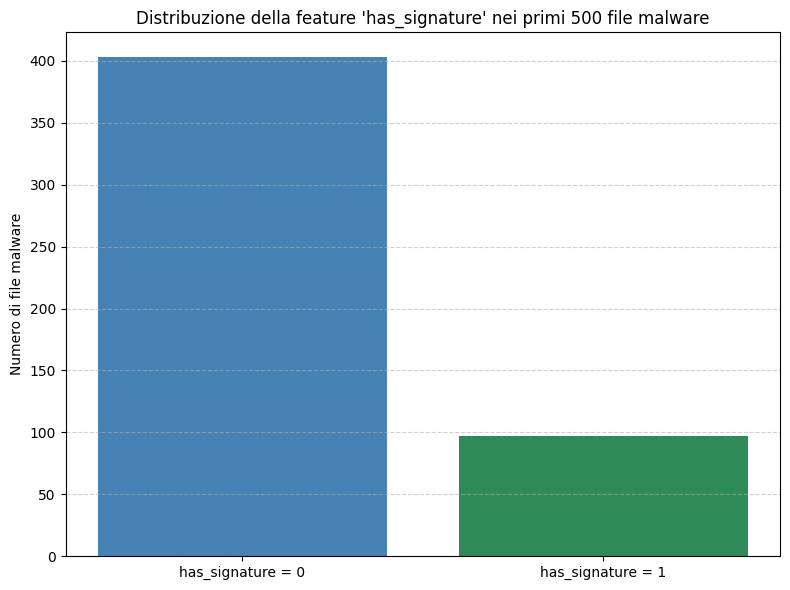

In [ ]:
import os
import matplotlib.pyplot as plt
from ember import PEFeatureExtractor  # Assicurati che questa import funzioni nel tuo ambiente

# Percorso alla cartella dei malware
malware_dir = '/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/malware'

# Inizializza l'estrattore
extractor = PEFeatureExtractor(print_feature_warning=False)

# Contatori
sum_0 = 0  # has_signature = 0
sum_1 = 0  # has_signature = 1

# Analizza i primi 500 file
for i, malware_file in enumerate(os.listdir(malware_dir)):
    if i >= 500:
        break

    file_path = os.path.join(malware_dir, malware_file)
    try:
        with open(file_path, 'rb') as file:
            raw, processed = extractor.get_raw_and_processed_features(file.read(), 'general')
            sig = raw.get('has_signature', None)
            print(f"{i+1:03d}) File: {malware_file}")
            print("\tFeature 623 (has_signature):", sig)

            if sig == 0:
                sum_0 += 1
            elif sig == 1:
                sum_1 += 1

    except Exception as e:
        print(f"Errore durante il parsing del file: {malware_file}, errore: {e}")
        continue

# Stampa finale
print("✅ Malware con has_signature = 0:", sum_0)
print("✅ Malware con has_signature = 1:", sum_1)

# Istogramma
labels = ['has_signature = 0', 'has_signature = 1']
values = [sum_0, sum_1]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['steelblue', 'seagreen'])
plt.ylabel("Numero di file malware")
plt.title("Distribuzione della feature 'has_signature' nei primi 500 file malware")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

001) File: b039bc8a626729101420967f70f6ef8469b47b3a1357f14271b44a086338bf9e
	Feature 623 (has_signature): 1
002) File: b01afda35fe7ae222b1a5cb58d7a061c566904e6d53858b7f9ae76e3cd73dc03
	Feature 623 (has_signature): 0
003) File: f4bfec3ba96c1d1c8fc6d646f9a13872d4cb14b1fbd9fb3dbd37379160e83287
	Feature 623 (has_signature): 1
004) File: 1a0b917d701bae3277ba654f602976dd7720d5f993a54f3c2efc073a6a44a92d
	Feature 623 (has_signature): 1
005) File: 0f089f8a29745b24daa48139e713df7b0e2290a4ff03a598d639927166451327
	Feature 623 (has_signature): 1
006) File: 525c8187eed18f01f864deeefa2435369b20bca858306647d2f7baf815d59044
	Feature 623 (has_signature): 1
007) File: c7a8689a685d034a54839bd1e351b10e8b75d9dc37bd667eb0fafb4dc00cb059
	Feature 623 (has_signature): 1
008) File: 4ec1e861b02fbc1e3d77754db246a4f9009532f14b9e9179fe069da9f212f8ad
	Feature 623 (has_signature): 1
009) File: 0453f2bbc1ac8ba5d022fef42db460944ef555c0f959ea893a0f2bcd2b8fca55
	Feature 623 (has_signature): 1
010) File: dd0a25b972bafe19b

Unable to find the section associated with BOUND_IMPORT


076) File: 135ebb24723ee4062b4801fa89e05c7ab9923f12b01842245826aeb25369640e
	Feature 623 (has_signature): 0
077) File: 1040048fae373f9e9d0911faf58e9f5700987d503918187907d008a268d9ff66
	Feature 623 (has_signature): 1
078) File: e644e6ac2a5fe425a2a51d09597ffe7deafd8ca5e8139349dc64a86f9b219cbd
	Feature 623 (has_signature): 1
079) File: 0d93219accd32f8b453a778eae6aeeb6e8c8863602bf117bd7d23f8a3c44cdf3
	Feature 623 (has_signature): 1
080) File: 8d9eaaa3e29b2ee70f1ae731374ff33dce62c903e8526d58e741f6f9c34c385d
	Feature 623 (has_signature): 0
081) File: 7742c2a1052ede6c25610eb82e8b817be54e142bdf4690d5db896320e7d9acd7
	Feature 623 (has_signature): 1
082) File: d1103895fd73f541479ca1ba6514a067e8205ef8451590c8d69acd8bbdeb20b7
	Feature 623 (has_signature): 0
083) File: 73e0150404e7f15a26d5fc6ce59136d16957ffa8198ed27ba9ede2b9a2c8065e
	Feature 623 (has_signature): 1
084) File: 2582c19cdeeab00700a6d6284894135c77aa78e90d4fe4aa31526c3cd29c3a69
	Feature 623 (has_signature): 0
085) File: e0067fc3c5a57ed6d

Unable to find the section associated with GLOBAL_PTR


190) File: 4fea5fcfb1013127a17c8733d530dd008848decec9f88f751eca6af2aa179c89
	Feature 623 (has_signature): 1
191) File: 36fb86feddcceeeb482b8a051d46c0a52a90687946806adf750f32da3e4fe8b7
	Feature 623 (has_signature): 1
192) File: 8fd479dc7460c39fac04e9c549fafaf5cae9dbbf1f49e2326d57be9e2eb6f02b
	Feature 623 (has_signature): 0


Unable to find the section associated with GLOBAL_PTR


193) File: a3b6969515a0454de02a1972e63f55f84b5858c42dc71be78f7896b01744bd05
	Feature 623 (has_signature): 1
194) File: d96cc2731f1eeb56a64c9cda17e60c6d5f422328786a3a7be723962c18e31f03
	Feature 623 (has_signature): 0
195) File: 49ba11696f98188d4ee7f01da50379914cbe795bd287212f6c9194bc130e3d2c
	Feature 623 (has_signature): 0
196) File: 8ed1d9954050c4e2f5fbbcab0cf26de13eb046286eadc60f58931867c4121390
	Feature 623 (has_signature): 0
197) File: f200a6f55503f94b719034e2ea0cf663744c8804b928caf89520b3da0c3ba5b6
	Feature 623 (has_signature): 1
198) File: 8f13da51bd383e6889bee3517532712ef309249634a6e8ebc2fe3b5c2f7b4956
	Feature 623 (has_signature): 0
199) File: 3f0bcfe87a4329c3c35f96aab97554fbf98d3f655a878617062103e308cec249
	Feature 623 (has_signature): 0
200) File: 42cd99a6ce86f829f8219b0c70ac10d78eda219654908fbd4a576aa226a2578c
	Feature 623 (has_signature): 0
201) File: e9348ad3816c1d6be0dadd0b80266c3bc353074089dd7bddcba2b8828d91654d
	Feature 623 (has_signature): 0
202) File: 597e53a084d4ad943

Unable to find the section associated with EXCEPTION_TABLE


234) File: 91785b70a54551552bccc3431160c4777715cbf0ce73f8012fab9bb35f0cf3b3
	Feature 623 (has_signature): 1
235) File: 0517057e0efb073034ecfd56dcd23ddc46f9d57a81db9d63e6cd955765d65b43
	Feature 623 (has_signature): 1
236) File: 94e969b711a658c07996f232224da732c7af8aae6accb897fe1de30fce5043a2
	Feature 623 (has_signature): 0
237) File: 75ebf02be9c0270924bbbb2026ecfa24035d2a9b6d50a0f54744b9a747d4813f
	Feature 623 (has_signature): 1
238) File: edb8cda32b7d39aa5e0abc5e2d3c139ded3cf34924e3d4e9df32e79c683e8f0d
	Feature 623 (has_signature): 1
239) File: 5f3b27401a3643b8a4004c1f52c9d4ae7a6c1bfa514b190d0bc28debadf810ed
	Feature 623 (has_signature): 0
240) File: 28f012287b153eb93f4716cc7113a534a6e1ba8b62838f156733bc14f765e0b5
	Feature 623 (has_signature): 0
241) File: 1bcde061f5d8638bc01bedc2ae6359cb67c3a112ebad8315bc5972b4eff08143
	Feature 623 (has_signature): 0
242) File: 86f4c254505905e7184786f97e1e36e92a8786e0d57f14c969cad02cceb3d2b4
	Feature 623 (has_signature): 1
243) File: 21ef9dbd11f7187a6

Unable to find the section associated with BASE_RELOCATION_TABLE


244) File: 2a0171f777c6dd761be4615a013d0063b37d86f791f18212f49a59eadaefe8ab
	Feature 623 (has_signature): 0
245) File: 7c75b5878adec11aabe7c2faeffa054adac25eeb9655cc944f079ba6a328dd67
	Feature 623 (has_signature): 1
246) File: 6bc1eff62faa5b54d178f25b0d5e4942ae310aa92feee3d2d99a8001b04e57db
	Feature 623 (has_signature): 0
247) File: 61677e975d986c881161083849e93677d310da1fb7bd48fdd3853e9e7eb25271
	Feature 623 (has_signature): 1
248) File: f0513651c28f625e396b0b783aeb6857617cb563a546d6f9f1d773170b263da9
	Feature 623 (has_signature): 1
249) File: 73431d2b34ec379b11d985465149a7e27526e549839061b18d07991680eab72b
	Feature 623 (has_signature): 0
250) File: d8b8c32fcbc09fc43746114015638c29de66931d7ff35a3ba376b10823a9d911
	Feature 623 (has_signature): 1


TLS's template corrupted


251) File: 5fe84e7031a145cb01d3dd22ba0d569cbdf5b9e09fea0370ac9cfec735949490
	Feature 623 (has_signature): 1
252) File: ab3774ece8eb58520ab37723252802579e00d9aece6ab16c5c067377a0e544ce
	Feature 623 (has_signature): 1
253) File: 7752b89df210ae5655514d83a24076dc89cea9c45cca8b8d5141d964a44c4f33
	Feature 623 (has_signature): 1
254) File: 3cd9c66c53f2a2471e75672e32dc82b19310beabc25d970545da95ea8372c22a
	Feature 623 (has_signature): 1
255) File: 70d5d4d6b4117825702ce61682a5c6aa8a58cf4b99a12b60d966545de8680f7a
	Feature 623 (has_signature): 1
256) File: 54dded30c73ea8d40826aac7ef1120786833ffe782be6a68c43943032256deda
	Feature 623 (has_signature): 0
257) File: f4423017c43deb1c42884d83d80120d1e40d8f6fd0106606759b52a9a6cd3d6a
	Feature 623 (has_signature): 0
258) File: 3fe83a7c83a9cd3c5b723f6f13d85b1f4bf0cd548ee56b1e59bf7f9387d4329f
	Feature 623 (has_signature): 1
259) File: 098717779dddc113bad3e24217be40628cba2f9bb339e1c077f0241b2259b31a
	Feature 623 (has_signature): 1
260) File: d4ac5b3c525a5fd94

Unable to find the section associated with BOUND_IMPORT


336) File: ac3d5d8645b8e4ce478edbaf71c7d5bd30d0c97bb932fa269c304d5e806be6f3
	Feature 623 (has_signature): 0
337) File: a1b5601d5d94f414496e60448aaf37c619dd042492d0c024af20031c83359c17
	Feature 623 (has_signature): 0
338) File: 1e12b271aa6a3f52788e7e4b45b643df7eabdd8897d743f620cc577dd8080a39
	Feature 623 (has_signature): 1


Export.AddressTableEntries is too large (1246238497)


339) File: 8b824d97259d246d6d448e90d638e07170900e5440a968218e908c0e0237a843
	Feature 623 (has_signature): 1
340) File: cba59af17eed3d6cc9a70cdb2820e92d28a535fd51310909a2c5d5ed88b7d914
	Feature 623 (has_signature): 1
341) File: 5614916fbcd7eb600d7df550643f79de4b5bc9929df251b0f631d702384d9b64
	Feature 623 (has_signature): 1


Relocation corrupted: BlockSize is out of bound the binary's virtual size


342) File: 01198a647bdda0bc613091ebbfe7a86370c14eee3840d0bf9a4e71264a7e985b
	Feature 623 (has_signature): 0
343) File: feaaea2ade52869a10d34c2baf4268e41b60eb7b72a715ddae600e908d75ecf2
	Feature 623 (has_signature): 0
344) File: 5b57fe8f0a43584bfabd5a69747545bd8763dc5d041c9a26f5c5b7359923b4be
	Feature 623 (has_signature): 0
345) File: 6e3aa78f95e1353857a9491802e368c53690948d2a917348770fe78df367864d
	Feature 623 (has_signature): 1
346) File: 477aca2edd4bb8982180bc2d279234d067a45e43cf56c62e4de99cfe3876dd8e
	Feature 623 (has_signature): 1
347) File: 8b6ba6a7090e32b24666ef484ae8d24f445f0db9ed1c6b0d85591bb1963e8eae
	Feature 623 (has_signature): 1
348) File: 8b3554646d8b9a61174ea41bb5f7e379df1c4c14c034b759f71500d79f940d15
	Feature 623 (has_signature): 1
349) File: 894f016202b6534a10397bb195bcc41f77d6f27fe0cb29c4866b20c8509abdbd
	Feature 623 (has_signature): 0
350) File: 2e0a15b639ef0e126fa8f36688a45a4e600c221ec6cdff8a32adcfee786c279f
	Feature 623 (has_signature): 1
351) File: 100adb06ba6810646

Unable to find the section associated with BASE_RELOCATION_TABLE


426) File: b19c1fda6bb04fd1096c356593a81acf8b9c27ae4d4ef1a92c1946c0462154e4
	Feature 623 (has_signature): 0
427) File: 8b64474aa4a41493fd779e61bbca8b54563de9eb71d3e7eb740d0585a9325bbb
	Feature 623 (has_signature): 1
428) File: e9533d66d771f97b1273a8d35ee70e1cce7316b41d36abb886ba5b4bfa48119d
	Feature 623 (has_signature): 1
429) File: 1cae6786af03e4dd2f05d9c10898c77db84d4315a572eea90d1627dace89db16
	Feature 623 (has_signature): 1
430) File: 5a2bfd50e56d84071bd68fe1fc78b1f7ffa4b2164fe3b457dc7cc0042a4cb128
	Feature 623 (has_signature): 0
431) File: 9b6060c620b3502c42cf1ca907768413787f1dc98f037296dc0df734a5b04890
	Feature 623 (has_signature): 1
432) File: c697b58d40054f444a86431a76e9c267ac657b333d17a94afe73a1edd1be1c0d
	Feature 623 (has_signature): 1
433) File: 2bdc828db9d9766445c345e82751fa7ef94a089ec84565675edade3ec7eb5748
	Feature 623 (has_signature): 1
434) File: d1f2d5ef842ea6ae27f4621ae05f50fafecbdd40eb49ef06cb6161b9f0084c01
	Feature 623 (has_signature): 1
435) File: c95470bc12c116176

Unable to find the section associated with EXPORT_TABLE
Can't read the export table at 0x60f200


445) File: 4678ca7370dcac7dbb5e7801a300703f31bc6242730c6a4e406ffd75230a377a
	Feature 623 (has_signature): 1
446) File: 7a0c0b63d6d06ba5a302db3d2fac5875bb399f5dddaf27bec41f94d976d49075
	Feature 623 (has_signature): 1
447) File: a80b98af04b1db92fa9f95590a3414a72495fa45cbb84fa3ea19bacd81b85731
	Feature 623 (has_signature): 1
448) File: 2aaa090fa5872fb171f96abe104c8163ab8a4d3f649b0d847b46482fb9f66221
	Feature 623 (has_signature): 0
449) File: 28eae320096f7b6a3afde95d94be422d7955a232cdeb71e19d3d50feb09e7c1d
	Feature 623 (has_signature): 0
450) File: e412fc9018fb680d5303205c08735b73d680a902b38832cf853157f47a068036
	Feature 623 (has_signature): 1
451) File: 0c3865fea6119ab219653f06b033276e3f1c6068ef479cb24bee92089cb552f5
	Feature 623 (has_signature): 0
452) File: 12f2c4ae4a3f9ada33fde49f920cf56008f3a1abfea428341ce771d2f890df5f
	Feature 623 (has_signature): 1
453) File: 7cbb41a6fdd0d9461fc1066f8976ecc2ce912ba51335c02579ca4f31e8d67fc7
	Feature 623 (has_signature): 1
454) File: ab969ae3ec78abac5

Unable to find the section associated with BOUND_IMPORT


477) File: 52e582a637786cc08c438820d405175de32c0e192bda019f053a307c85dc176b
	Feature 623 (has_signature): 0
478) File: a6fe1704f30336d3b54d26dfd795a7a133049dac5a1826b02401af00563a7fca
	Feature 623 (has_signature): 1
479) File: 51a7bdb8cccbd941b8ebdc2287b8480b9aa5760283fa281c269555945da19ad1
	Feature 623 (has_signature): 1
480) File: 724a8158212c4a7f185430b9767591afa0d18ed7118af1ca92682de084b20ce9
	Feature 623 (has_signature): 0
481) File: 28dfb1cc7440abd4ca4cfd570b67bb5c8f87646013b4a68f0d5bc7ee35339952
	Feature 623 (has_signature): 0
482) File: eff5ece9478f9fc46502023666150e99cc785e4d43471c9776a845f4a788086e
	Feature 623 (has_signature): 0
483) File: ed161c311f1855f2ab31c7c8afb398b106f24c0d5eff3c787916aee59164ddf5
	Feature 623 (has_signature): 0
484) File: 25b10046196b805f79bb9984f4e056002d277138934de5cc0a322a700d631279
	Feature 623 (has_signature): 1
485) File: b85ccb7acd12f3c4f5c086f55f3ded01ed58bfaa4d9cd7929c24542329721080
	Feature 623 (has_signature): 0
486) File: 28ca47f62fde84841

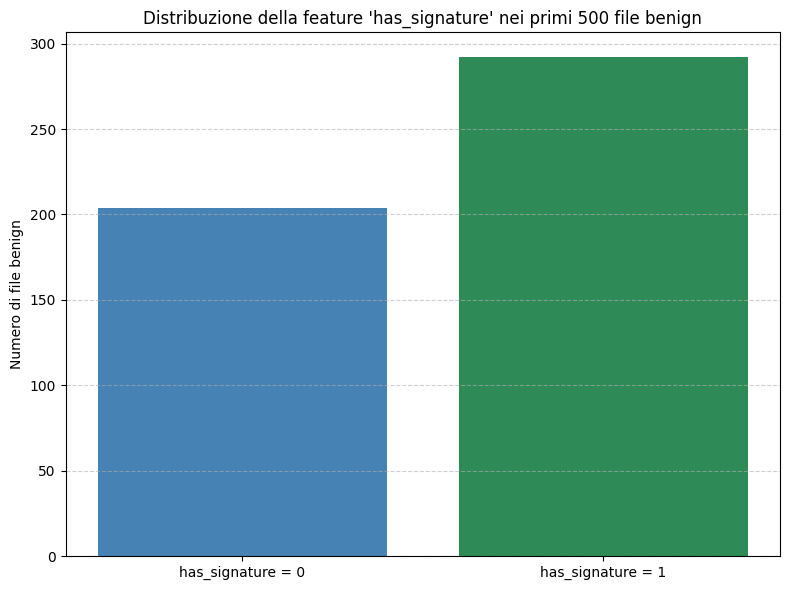

In [ ]:
import os
import matplotlib.pyplot as plt
from ember import PEFeatureExtractor  # Assicurati che questa import funzioni nel tuo ambiente

# Percorso alla cartella dei benign
benign_dir = '/content/drive/Shareddrives/AI for Cybersecurity/Consegna/Dataset1/training/benign'

# Inizializza l'estrattore
extractor = PEFeatureExtractor(print_feature_warning=False)

# Contatori
sum_0 = 0  # has_signature = 0
sum_1 = 0  # has_signature = 1

# Analizza i primi 500 file
for i, benign_file in enumerate(os.listdir(benign_dir)):
    if i >= 500:
        break

    file_path = os.path.join(benign_dir, benign_file)
    try:
        with open(file_path, 'rb') as file:
            raw, processed = extractor.get_raw_and_processed_features(file.read(), 'general')
            sig = raw.get('has_signature', None)
            print(f"{i+1:03d}) File: {benign_file}")
            print("\tFeature 623 (has_signature):", sig)

            if sig == 0:
                sum_0 += 1
            elif sig == 1:
                sum_1 += 1

    except Exception as e:
        print(f"Errore durante il parsing del file: {benign_file}, errore: {e}")
        continue

# Stampa finale
print("✅ benign con has_signature = 0:", sum_0)
print("✅ benign con has_signature = 1:", sum_1)

# Istogramma
labels = ['has_signature = 0', 'has_signature = 1']
values = [sum_0, sum_1]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['steelblue', 'seagreen'])
plt.ylabel("Numero di file benign")
plt.title("Distribuzione della feature 'has_signature' nei primi 500 file benign")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Rimozione delle features

In [ ]:
import copy

# Indici da rimuovere (tutti inclusivi)
ranges_to_remove = (
    list(range(626, 637)) +     # coff-machine (header)
    list(range(647, 657)) +     # optional-subsystem (header)
    list(range(623, 624)) +     # has signature
    list(range(2359, 2361))     # Data directories
)

def remove_features_from_dataset(features, feature_indices_to_remove):
    """
    Rimuove le feature specificate (impostandole a 0) da un dataset
    """
    features_filtered = copy.deepcopy(features)  # Crea una copia profonda

    for feature_vector in features_filtered:
        for idx in feature_indices_to_remove:
            feature_vector[idx] = 0

    return features_filtered

# Applica la rimozione
x_train_filtered = remove_features_from_dataset(x_train, ranges_to_remove)
x_validation_filtered = remove_features_from_dataset(x_validation, ranges_to_remove)

# Se vuoi anche su test e dataset2:
# x_test_filtered = remove_features_from_dataset(x_test, ranges_to_remove)
# x_dataset2_filtered = remove_features_from_dataset(x_dataset2, ranges_to_remove)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score

# Definizione del classificatore base
rf_base = RandomForestClassifier(random_state=42)

# Griglia degli iperparametri
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 50],
    'min_samples_leaf': [10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', {0:1, 1:5}, {0:1, 1:10}]
}

# Crea la lista di tutte le combinazioni di parametri
param_list = list(ParameterGrid(param_grid))

# Variabili per tenere traccia del miglior modello
best_accuracy = 0
best_params = None
best_model_filtered = None

# Ciclo manuale su tutte le combinazioni
for params in param_list:
    model = RandomForestClassifier(random_state=42, **params)
    model.fit(x_train_filtered, y_train)

    y_pred = model.predict(x_validation_filtered)
    accuracy = accuracy_score(y_validation, y_pred)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model_filtered = model

# ✅ Risultati
print("✅ Migliori parametri trovati massimizzando: Accuracy")
print(best_params)
print(f"📏 Accuracy: {best_accuracy:.3f}")

# ROC

In [ ]:
# Griglia degli iperparametri
param_grid = {
    'n_estimators': [50, 100],                                # meno alberi per evitare overfitting iniziale
    'max_depth': [10, 20, 50],                                # profondità limitata = meno complessità
    'min_samples_leaf': [20, 30],                             # foglie più "grandi" = meno complessità
    'max_features': ['sqrt', 'log2'],                         # meno feature per split = più diversità, meno overfitting
    'class_weight': ['balanced', {0:1, 1:5}, {0:1, 1:10}]     # gestione sbilanciamento
}

param_list = list(ParameterGrid(param_grid))

# --- Inizializzazione ---
best_params = None
best_model_filtered = None
best_accuracy = 0
best_f1 = 0
best_recall = 0
best_score = 0
alpha = 0.7   # Peso sulla Recall
beta = 0.3    # Peso sull'F1

# --- Grid Search con metrica combinata ---
for params in param_list:
    model = RandomForestClassifier(random_state=42, **params)
    model.fit(x_train_filtered, y_train)

    y_pred = model.predict(x_validation_filtered)
    accuracy = accuracy_score(y_validation, y_pred)
    f1 = f1_score(y_validation, y_pred)
    recall_1 = recall_score(y_validation, y_pred, pos_label=1)

    combined_score = (alpha * recall_1) + (beta * f1)

    if combined_score > best_score:
        best_accuracy = accuracy
        best_score = combined_score
        best_recall = recall_1
        best_f1 = f1
        best_params = params
        best_model_filtered = model

# --- Output modello migliore---
print("✅ Migliori parametri trovati massimizzando: 0.7*Recall + 0.3*F1")
print(best_params)
print(f"🔎 Accuracy classe 1: {best_accuracy:.3f}")
print(f"🔎 Recall classe 1: {best_recall:.3f}")
print(f"📏 F1 score: {best_f1:.3f}")
print(f"🎯 Score combinato: {best_score:.3f}")

✅ Migliori parametri trovati massimizzando: 0.7*Recall + 0.3*F1
{'class_weight': {0: 1, 1: 5}, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 100}
🔎 Accuracy classe 1: 0.931
🔎 Recall classe 1: 0.992
📏 F1 score: 0.937
🎯 Score combinato: 0.976


✅ Soglia scelta: 0.512
🎯 Recall alla soglia: 0.992
🎯 F1 alla soglia: 0.939


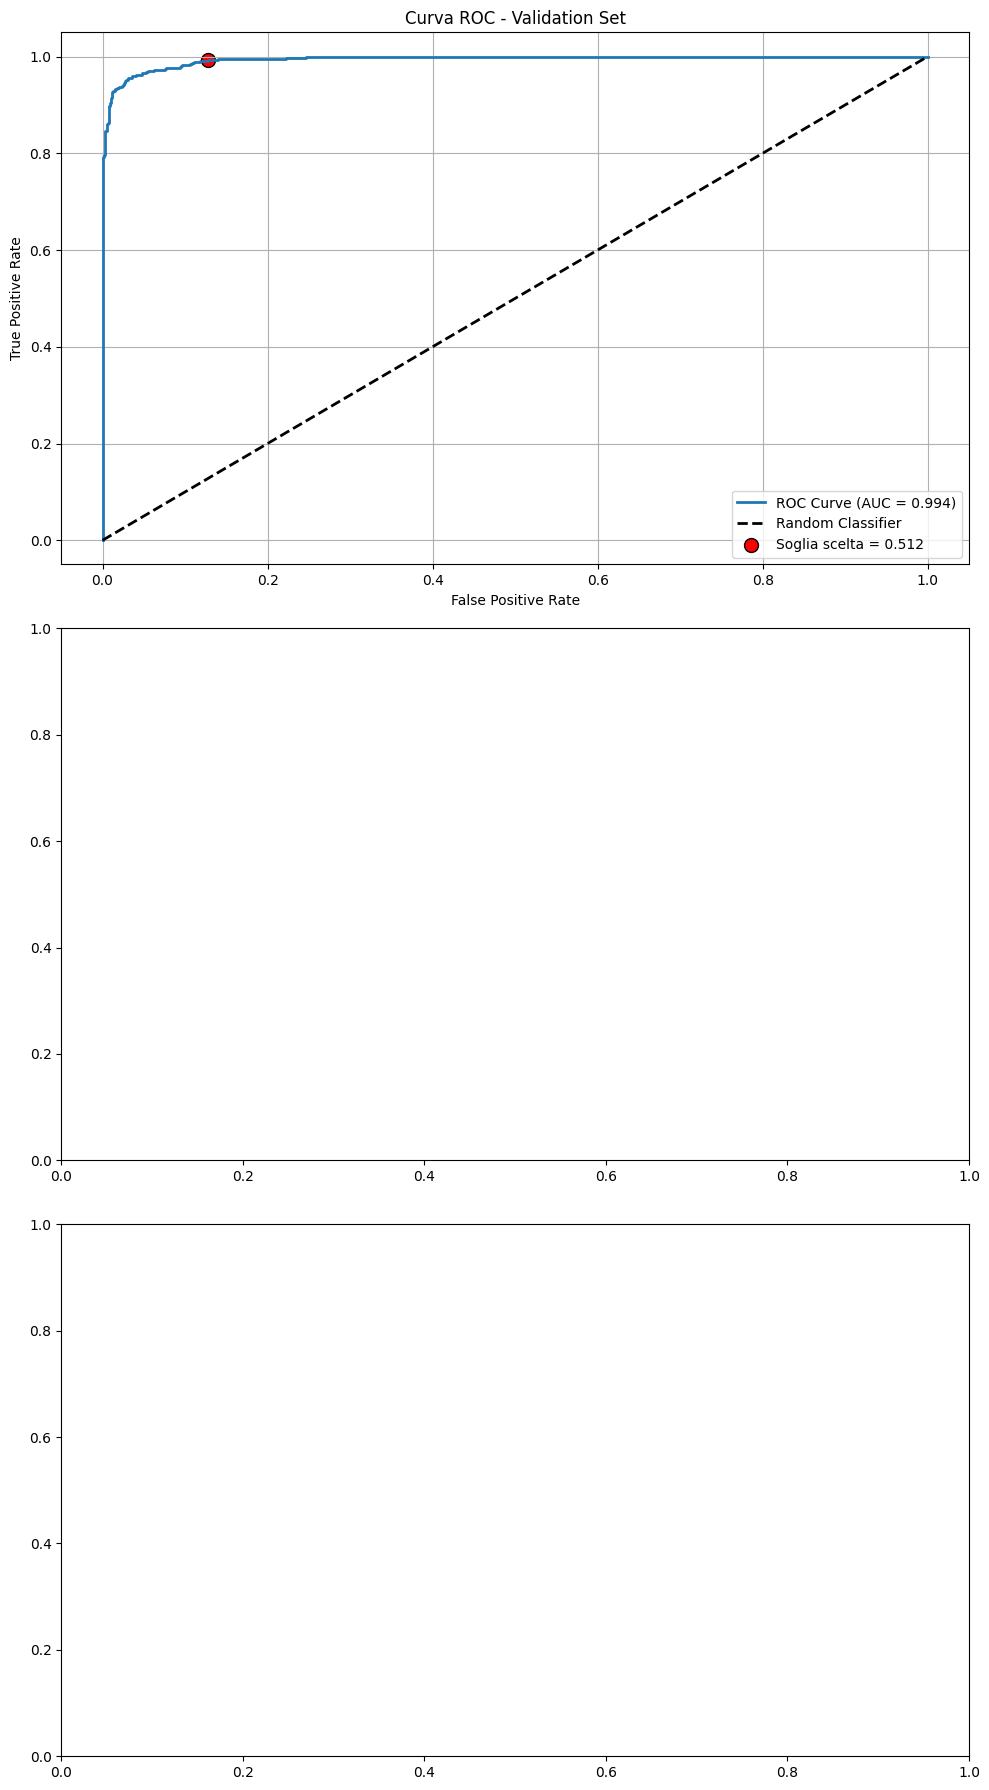

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, recall_score, f1_score

# Predizione delle probabilità
y_val_proba = best_model_filtered.predict_proba(x_validation)[:, 1]

# Calcolo curva ROC
fpr, tpr, thresholds = roc_curve(y_validation, y_val_proba)
roc_auc = roc_auc_score(y_validation, y_val_proba)

# Calcolo F1-Score e Recall Classe 1 per ogni soglia
f1_scores = []
recall_positives = []

for thresh in thresholds:
    y_pred_thresh = (y_val_proba >= thresh).astype(int)

    recall_1 = recall_score(y_validation, y_pred_thresh, pos_label=1)
    f1 = f1_score(y_validation, y_pred_thresh)

    recall_positives.append(recall_1)
    f1_scores.append(f1)

recall_positives = np.array(recall_positives)
f1_scores = np.array(f1_scores)

# --- Definizione obiettivo combinato ---
# Normalizzazione
recall_norm = (recall_positives - recall_positives.min()) / (recall_positives.max() - recall_positives.min())
f1_norm = (f1_scores - f1_scores.min()) / (f1_scores.max() - f1_scores.min())

# Pesi: priorità alla Recall
alpha = 0.7   # Peso sulla Recall
beta = 0.3    # Peso sull'F1

# Score combinato
multi_objective_score = (alpha * recall_norm) + (beta * f1_norm)

# Soglia che massimizza lo score combinato
best_idx = np.argmax(multi_objective_score)
best_threshold = thresholds[best_idx]

print(f"✅ Soglia scelta: {best_threshold:.3f}")
print(f"🎯 Recall alla soglia: {recall_positives[best_idx]:.3f}")
print(f"🎯 F1 alla soglia: {f1_scores[best_idx]:.3f}")

# --- PLOTTAGGI ---

fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# 1. Curva ROC
axs[0].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', lw=2)
axs[0].plot([0, 1], [0, 1], 'k--', lw=2, label="Random Classifier")
axs[0].scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Soglia scelta = {best_threshold:.3f}', s=100, edgecolors='black')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('Curva ROC - Validation Set')
axs[0].legend(loc='lower right')
axs[0].grid(True)

plt.tight_layout()
plt.show()

# Valutazioni finali


📊 Report sul validation set:
Accuracy: 0.9309803921568628
Recall: 0.9923664122137404
F1 Score: 0.9365994236311239
Classification report
               precision    recall  f1-score   support

         0.0       0.99      0.87      0.92      1240
         1.0       0.89      0.99      0.94      1310

    accuracy                           0.93      2550
   macro avg       0.94      0.93      0.93      2550
weighted avg       0.94      0.93      0.93      2550


📊 Valutazione sul validation set (soglia 0.5119163752873883):
✅ Accuracy (0.5119163752873883): 0.9341176470588235
✅ Recall (0.5119163752873883): 0.9923664122137404
🎯 F1 score (soglia 0.5119163752873883): 0.9393063583815029


[Text(0.5, 39.58333333333332, 'Predicted Label'),
 Text(50.83333333333333, 0.5, 'True Label')]

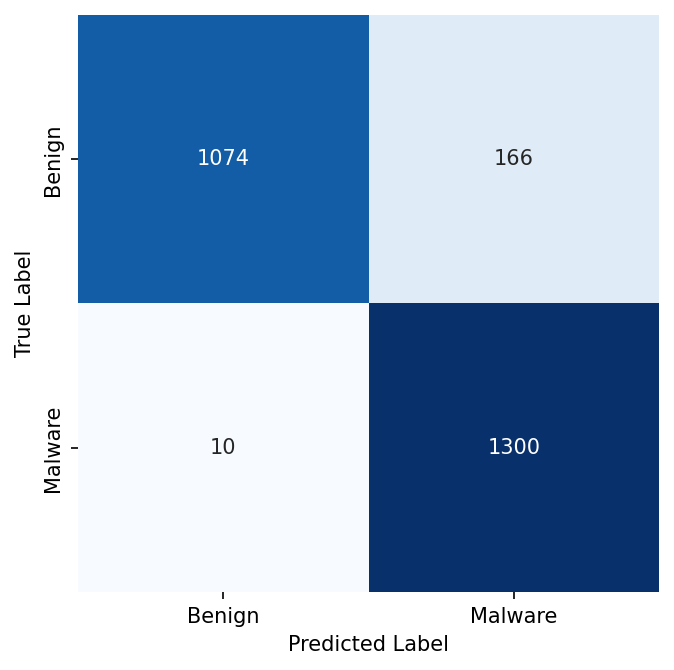

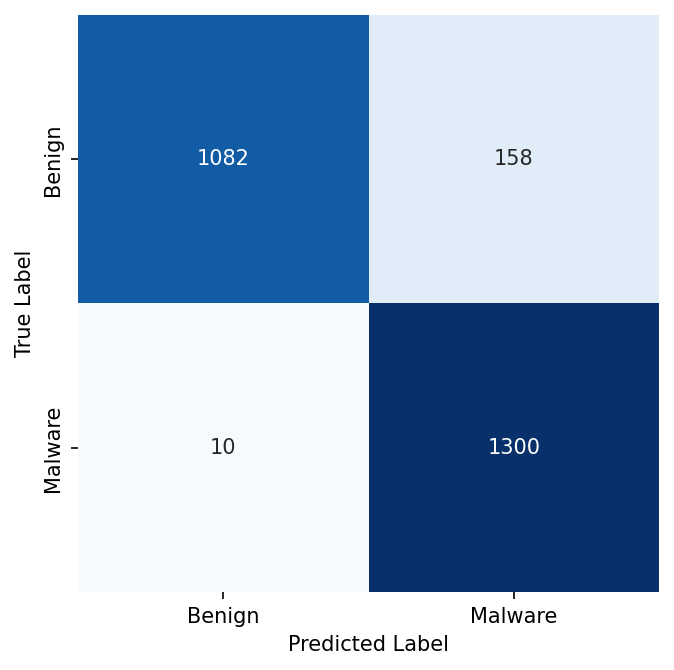

In [ ]:
# 📊 Validation set
y_pred_val = best_model_filtered.predict(x_validation_filtered)
print("\n📊 Report sul validation set:")
print("Accuracy:", accuracy_score(y_validation, y_pred_val))
print("Recall:", recall_score(y_validation, y_pred_val))
print("F1 Score:", f1_score(y_validation, y_pred_val))

conf_matrix = confusion_matrix(y_validation, y_pred_val, normalize=None)
pyplot.figure(figsize=(5, 5), dpi = 150)
s = sns.heatmap(conf_matrix, cmap='Blues', annot=True, xticklabels=['Benign' , 'Malware'],
                yticklabels=['Benign' , 'Malware'], cbar=False, fmt='g')
s.set(xlabel='Predicted Label', ylabel='True Label')
print("Classification report\n %s" % (classification_report(y_validation, y_pred_val)))

# 🔵 Predizione su validation abbassando la soglia
y_pred_proba_val2 = best_model_filtered.predict_proba(x_validation_filtered)[:, 1]
y_pred_val_04 = (y_pred_proba_val2 >= best_threshold).astype(int)

print(f"\n📊 Valutazione sul validation set (soglia {best_threshold}):")
print(f"✅ Accuracy ({best_threshold}):", accuracy_score(y_validation, y_pred_val_04))
print(f"✅ Recall ({best_threshold}):", recall_score(y_validation, y_pred_val_04))
print(f"🎯 F1 score (soglia {best_threshold}):", f1_score(y_validation, y_pred_val_04))

conf_matrix = confusion_matrix(y_validation, y_pred_val_04, normalize=None)
pyplot.figure(figsize=(5, 5), dpi = 150)
s = sns.heatmap(conf_matrix, cmap='Blues', annot=True, xticklabels=['Benign' , 'Malware'],
                yticklabels=['Benign' , 'Malware'], cbar=False, fmt='g')
s.set(xlabel='Predicted Label', ylabel='True Label')


📊 Report sul test set:
Accuracy: 0.9346970889063729
Recall: 0.9908396946564886
F1 Score: 0.939898624185373
Classification report
               precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       616
         1.0       0.89      0.99      0.94       655

    accuracy                           0.93      1271
   macro avg       0.94      0.93      0.93      1271
weighted avg       0.94      0.93      0.93      1271


📊 Valutazione sul test set (soglia 0.5119163752873883):
✅ Accuracy (0.5119163752873883): 0.9386309992132179
✅ Recall (0.5119163752873883): 0.9908396946564886
🎯 F1 score (soglia 0.5119163752873883): 0.9433139534883721
Classification report
               precision    recall  f1-score   support

         0.0       0.99      0.88      0.93       616
         1.0       0.90      0.99      0.94       655

    accuracy                           0.94      1271
   macro avg       0.94      0.94      0.94      1271
weighted avg       0.94      

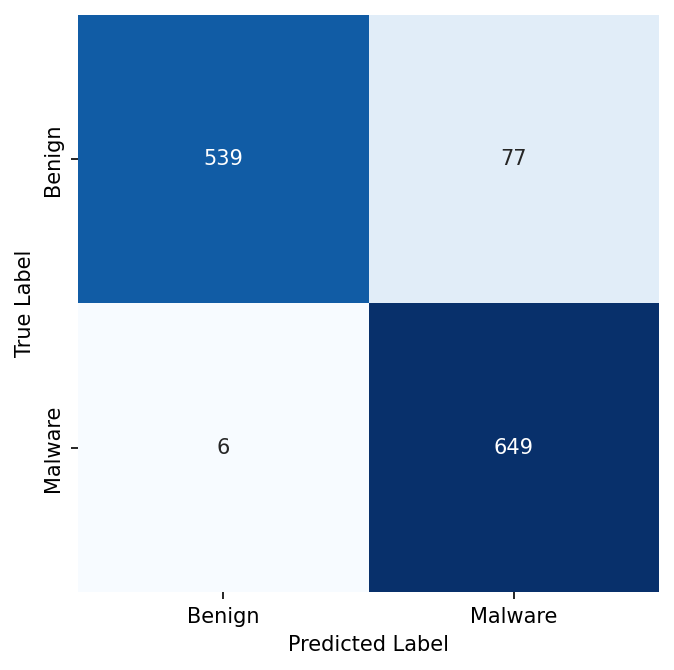

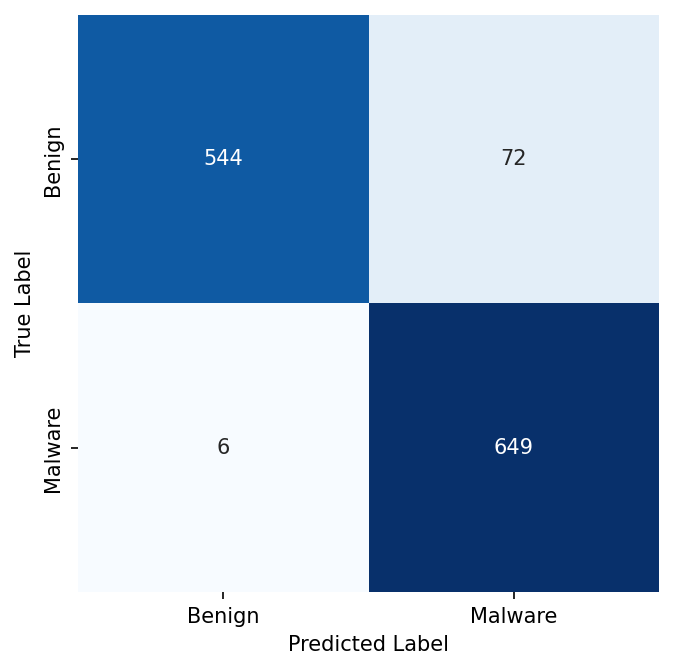

In [ ]:
# 🧪 Test set
y_pred_test = best_model_filtered.predict(x_test)
print("\n📊 Report sul test set:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))

conf_matrix = confusion_matrix(y_test, y_pred_test, normalize=None)
pyplot.figure(figsize=(5, 5), dpi = 150)
s = sns.heatmap(conf_matrix, cmap='Blues', annot=True, xticklabels=['Benign' , 'Malware'],
                yticklabels=['Benign' , 'Malware'], cbar=False, fmt='g')
s.set(xlabel='Predicted Label', ylabel='True Label')
print("Classification report\n %s" % (classification_report(y_test, y_pred_test)))

# 🔵 Predizione su validation abbassando la soglia
y_pred_proba_test2 = best_model_filtered.predict_proba(x_test)[:, 1]
y_pred_test_04 = (y_pred_proba_test2 >= best_threshold).astype(int)

print(f"\n📊 Valutazione sul test set (soglia {best_threshold}):")
print(f"✅ Accuracy ({best_threshold}):", accuracy_score(y_test, y_pred_test_04))
print(f"✅ Recall ({best_threshold}):", recall_score(y_test, y_pred_test_04))
print(f"🎯 F1 score (soglia {best_threshold}):", f1_score(y_test, y_pred_test_04))

conf_matrix = confusion_matrix(y_test, y_pred_test_04, normalize=None)
pyplot.figure(figsize=(5, 5), dpi = 150)
s = sns.heatmap(conf_matrix, cmap='Blues', annot=True, xticklabels=['Benign' , 'Malware'],
                yticklabels=['Benign' , 'Malware'], cbar=False, fmt='g')
s.set(xlabel='Predicted Label', ylabel='True Label')
print("Classification report\n %s" % (classification_report(y_test, y_pred_test_04)))


📊 Valutazione finale su dataset2:
✅ Accuracy su dataset2: 0.781491002570694
✅ Recall su dataset2: 0.7232323232323232
F1 score on test set: 0.7711362412493269
Classification report
               precision    recall  f1-score   support

         0.0       0.75      0.84      0.79       955
         1.0       0.83      0.72      0.77       990

    accuracy                           0.78      1945
   macro avg       0.79      0.78      0.78      1945
weighted avg       0.79      0.78      0.78      1945


📊 Valutazione finale su dataset2 (soglia 0.5119163752873883):
✅ Accuracy su dataset2 (0.5119163752873883): 0.7809768637532134
✅ Recall su dataset2 (0.5119163752873883): 0.7131313131313132
🎯 F1 score su dataset2 (soglia 0.5119163752873883): 0.7682263329706203
Classification report
               precision    recall  f1-score   support

         0.0       0.74      0.85      0.79       955
         1.0       0.83      0.71      0.77       990

    accuracy                           0.78 

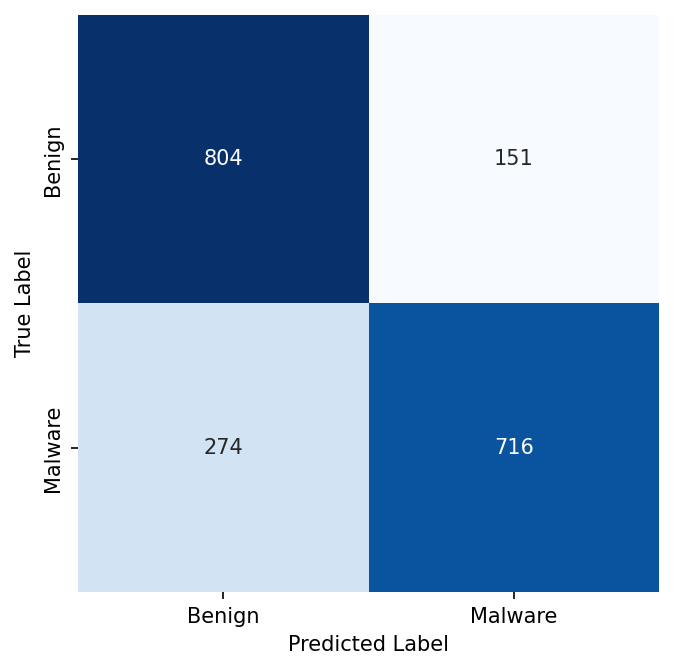

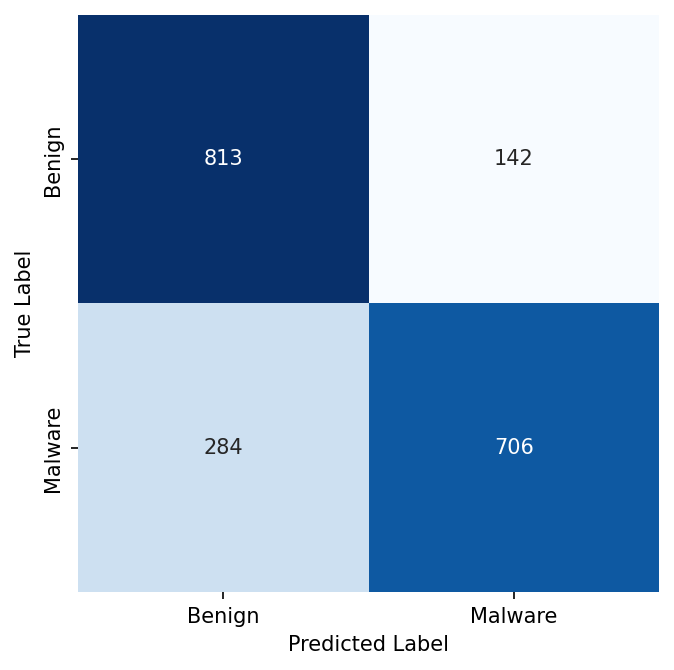

In [ ]:
# 🔵 Predizione su dataset2 con soglia normale (0.5)
y_pred_dataset2 = best_model_filtered.predict(x_dataset2)

print("\n📊 Valutazione finale su dataset2:")
print("✅ Accuracy su dataset2:", accuracy_score(y_dataset2, y_pred_dataset2))
print("✅ Recall su dataset2:", recall_score(y_dataset2, y_pred_dataset2))
print("F1 score on test set:", f1_score(y_dataset2, y_pred_dataset2))

conf_matrix = confusion_matrix(y_dataset2, y_pred_dataset2, normalize=None)
pyplot.figure(figsize=(5, 5), dpi = 150)
s = sns.heatmap(conf_matrix, cmap='Blues', annot=True, xticklabels=['Benign' , 'Malware'],
                yticklabels=['Benign' , 'Malware'], cbar=False, fmt='g')
s.set(xlabel='Predicted Label', ylabel='True Label')
print("Classification report\n %s" % (classification_report(y_dataset2, y_pred_dataset2)))

# 🔵 Predizione su dataset2 abbassando la soglia
y_pred_proba_dataset2 = best_model_filtered.predict_proba(x_dataset2)[:, 1]
y_pred_dataset2_04 = (y_pred_proba_dataset2 >= best_threshold).astype(int)

print(f"\n📊 Valutazione finale su dataset2 (soglia {best_threshold}):")
print(f"✅ Accuracy su dataset2 ({best_threshold}):", accuracy_score(y_dataset2, y_pred_dataset2_04))
print(f"✅ Recall su dataset2 ({best_threshold}):", recall_score(y_dataset2, y_pred_dataset2_04))
print(f"🎯 F1 score su dataset2 (soglia {best_threshold}):", f1_score(y_dataset2, y_pred_dataset2_04))

conf_matrix = confusion_matrix(y_dataset2, y_pred_dataset2_04, normalize=None)
pyplot.figure(figsize=(5, 5), dpi = 150)
s = sns.heatmap(conf_matrix, cmap='Blues', annot=True, xticklabels=['Benign' , 'Malware'],
                yticklabels=['Benign' , 'Malware'], cbar=False, fmt='g')
s.set(xlabel='Predicted Label', ylabel='True Label')
print("Classification report\n %s" % (classification_report(y_dataset2, y_pred_dataset2_04)))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, f1_score, accuracy_score, classification_report
import numpy as np

# Unisci training e validation
X = np.vstack((x_train_filtered, x_validation_filtered))
y = np.hstack((y_train, y_validation))

# Parametri ottimali trovati in fase di tuning
best_params = {
    'class_weight': {0: 1, 1: 5},
    'criterion': 'gini',
    'max_depth': 50,
    'max_features': 'sqrt',
    'min_samples_leaf': 20,
    'n_estimators': 100,
    'random_state': 42
}

# Soglia personalizzata
threshold = 0.487

# Allena il modello finale su tutti i dati
final_model = RandomForestClassifier(**best_params)
final_model.fit(X, y)

# Predici sul test set usando la soglia personalizzata
y_proba_test = final_model.predict_proba(x_test)[:, 1]
y_pred_test = (y_proba_test >= threshold).astype(int)

# Report completo
print("\n📊 Report sul test set:")
print(classification_report(y_test, y_pred_test))
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))


📊 Report sul test set:
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94       616
         1.0       0.91      0.99      0.95       655

    accuracy                           0.94      1271
   macro avg       0.95      0.94      0.94      1271
weighted avg       0.95      0.94      0.94      1271

Accuracy: 0.9425649095200629
Recall: 0.9893129770992366
F1 Score: 0.9466764061358656


In [ ]:
import joblib
import os

# Cartella dove salvare il modello
model_dir = "/content/drive/Shareddrives/AI for Cybersecurity/Consegna/ML Model"
os.makedirs(model_dir, exist_ok=True)

# Percorso completo del file
model_path = os.path.join(model_dir, "random_forest_migliore.pkl")

# Salva il modello
joblib.dump(best_model_filtered, model_path)
print(f"📦 Modello salvato in: {model_path}")

📦 Modello salvato in: /content/drive/Shareddrives/AI for Cybersecurity/Consegna/ML Model/random_forest_migliore.pkl


In [ ]:
# Carica il modello salvato
import joblib
import os
best_model_filtered = joblib.load("/content/drive/Shareddrives/AI for Cybersecurity/Consegna/ML Model/random_forest_migliore.pkl")

# Stampa i parametri del modello
params = best_model_filtered.get_params()
print(params)


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {0: 1, 1: 5}, 'criterion': 'gini', 'max_depth': 50, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
